### Import Statements

In [1]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

In [2]:
import bioframe as bf

In [3]:
import plotly.express as px

In [4]:
from Bio import SeqIO
import plotly.express as px

# https://github.com/ipython/ipython/issues/10627
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [5]:
import ete3 as rec
import ete3 as ETE

from ete3 import Tree

In [6]:
import json

#### Pandas Viewing Settings

In [7]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [8]:
import time

# Import/parse processed H37rv genome annotations

In [9]:
RepoRef_Dir = "../../References"

#ESX_Genes_List_TSV = f"{RepoRef_Dir}/190927_H37rv_ListOf_ESXgenes.tsv"

AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir = f"{RepoRef_Dir}/201027_H37rv_AnnotatedGenes_And_IntergenicRegions"
H37Rv_GenomeAnnotations_Genes_TSV = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.Genes.tsv"
H37Rv_GenomeAnnotations_IntergenicRegions_TSV = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.IntergenicRegions.tsv"
H37Rv_GenomeAnnotations_Genes_And_IntergenicRegions_TSV = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.Genes.And.IntergenicRegions.tsv"    
H37Rv_GenomeAnnotations_Genes_And_IntergenicRegions_BED = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.Genes.And.IntergenicRegions.bed"

## H37Rv Gene Annotations TSV
H37Rv_GenomeAnno_Genes_DF = pd.read_csv(H37Rv_GenomeAnnotations_Genes_TSV, sep = "\t")
H37Rv_GeneInfo_Subset_DF = H37Rv_GenomeAnno_Genes_DF[["H37rv_GeneID", "Symbol", "Feature", "Functional_Category", "Is_Pseudogene", "Product", "PEandPPE_Subfamily", "ExcludedGroup_Category"]]

RvID_To_Symbol_Dict = dict(H37Rv_GeneInfo_Subset_DF[['H37rv_GeneID', 'Symbol']].values)
Symbol_To_FuncCat_Dict = dict(H37Rv_GeneInfo_Subset_DF[['Symbol', 'Functional_Category']].values)
#Esx_Genes_DF = pd.read_csv(ESX_Genes_List_TSV, sep = '\t')



In [10]:
H37Rv_GenomeAnno_Genes_DF.head(5)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,Feature,Functional_Category,Is_Pseudogene,Product,PEandPPE_Subfamily,ExcludedGroup_Category
0,NC_000962.3,0,1524,+,Rv0001,dnaA,CDS,information pathways,No,Chromosomal replication initiator protein DnaA,None,NotExcluded
1,NC_000962.3,2051,3260,+,Rv0002,dnaN,CDS,information pathways,No,DNA polymerase III (beta chain) DnaN (DNA nucl...,None,NotExcluded
2,NC_000962.3,3279,4437,+,Rv0003,recF,CDS,information pathways,No,DNA replication and repair protein RecF (singl...,None,NotExcluded
3,NC_000962.3,4433,4997,+,Rv0004,Rv0004,CDS,conserved hypotheticals,No,Conserved hypothetical protein,None,NotExcluded
4,NC_000962.3,5239,7267,+,Rv0005,gyrB,CDS,information pathways,No,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,None,NotExcluded


In [11]:
H37Rv_GenomeAnno_Genes_DF["Functional_Category"].value_counts()

conserved hypotheticals                    1042
intermediary metabolism and respiration     936
cell wall and cell processes                772
lipid metabolism                            272
information pathways                        242
virulence, detoxification, adaptation       239
regulatory proteins                         198
PE/PPE                                      168
insertion seqs and phages                   147
stable RNAs                                  48
unknown                                      15
Name: Functional_Category, dtype: int64

# Parse sample metadata & preprocessed genome info/results

In [12]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"
!mkdir $InputAsmPath_Dir

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"


mkdir: cannot create directory ‘../../Data/231121.InputAsmTSVs.MtbSetV3.151CI’: File exists


## Parse sample Metadata (N = 151)

In [13]:

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

#print(','.join(SampleIDs_151CI_SOI) )

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [14]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

#MtbWGA_SMK_Pipeline_OutputDir = WGA_SMK_Outputs_Dir + "/220427_WGA158CI_V1"
WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"
MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir

## Define PATHS relevant to Minigraph analysis

In [15]:
target_OutputDir = MtbWGA_SMK_Pipeline_OutputDir

Minigraph_158CI_OutDir = f"{target_OutputDir}/Minigraph"

MG_WGA158CI_GFA = f"{Minigraph_158CI_OutDir}/Minigraph_H37rv_Vs_158CI.V1.gfa"
MG_WGA158CI_Bubble_SV_BED = f"{Minigraph_158CI_OutDir}/Minigraph_H37rv_Vs_158CI.V1.Bubble.SV.bed"
MG_WGA158CI_Stable_FA = f"{Minigraph_158CI_OutDir}/Minigraph_H37rv_Vs_158CI.V1.Stable.fa"

MG_WGA158CI_MergedSVInfo_TSV = f"{Minigraph_158CI_OutDir}/Minigraph_H37rv_Vs_158CI.MergedSV.Info.tsv"

MG_WGA158CI_MergedSVInfo_SVVCF = f"{Minigraph_158CI_OutDir}/Minigraph_H37rv_Vs_158CI.MergedSV.Info.svvcf"


In [16]:
Minigraph_158CI_OutDir

'/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/Minigraph'

In [17]:
#!ls -alh $Minigraph_158CI_OutDir

In [18]:
!gfatools stat $MG_WGA158CI_GFA

Number of segments: 3138
Number of links: 4705
Number of arcs: 9410
Max rank: 129
Total segment length: 5196363
Average segment length: 1655.947
Sum of rank-0 segment lengths: 4411532
Max degree: 8
Average degree: 1.499
[M::main] Version: 0.5-r253-dirty
[M::main] CMD: gfatools stat /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/Minigraph/Minigraph_H37rv_Vs_158CI.V1.gfa
[M::main] Real time: 0.022 sec; CPU: 0.038 sec


## Read in SV Info TSV (From Minigraph)

In [19]:
Header_WiSamplesIDs_InOrderSV = ["Chr", "Start", "End", "Info", "FORMAT",
       'NC_000962.3','N0072','N0153','TB3113','TB1236','TB2659','TB2780','TB1612','TB2512','TB2981','TB3091',
       'M0003941_3','TB3368','N0145','N0155','TB2995','TB3396','N0004','N1274','N0054','02_R1179','01_R1134',
     'M0017522_5','M0016395_7','M0010874_7','02_R1708','02_R0894','01_R1430','M0014888_3','02_R1896','TB4620',
     'TB3162','MT_0080','TB3054','TB3251','M0016737_0','TB2661','TB3237','TB3169','TB3386','TB3334','M0011368_9',
     'TB2968','N1272','N1176','N1202','N1177','N0091','RW-TB008','9050-05','4549-04','696-05','702-06','706-05',
     '8129-04','3003-06','8651-04','QC-3','QC-9','QC-5','QC-8','QC-10','QC-4','QC-7','QC-6','QC-1','mada_1-10',
     'mada_2-46','mada_1-1','mada_1-36','mada_1-39','mada_1-51','mada_1-44','mada_117','mada_118','mada_122',
     'mada_107','R27252','R23887','R30215','R30078','R29816','R30234','18_0621851','R36431','R28703','mada_115',
     'mada_2-42','R31095','R28012','R37765','R27657','R25048','R24120','R28581','R29598','mada_1-11','R24100',
     'R21408','R20574','R20260','R18043','R22601','R23146','R32929','R21893','R30420','R26778','R26791','R28980',
     'R27725','R18040','R27937','mada_1-30','mada_2-31','mada_1-41','R21770','R21839','mada_1-32','R30396',
     'R21363','R20896','mada_102','mada_129','mada_139','mada_151','mada_105','R15311','mada_103','mada_2-25',
     'mada_112','mada_124','mada_126','mada_120','R23571','mada_128','mada_1-12','mada_1-15','mada_2-1','mada_1-53',
     'mada_1-50','mada_123','mada_2-53','mada_1-38','S0070-08','S0085-01','S0107-01','S0089-01','S0256-08','S0123-01',
     'S0106-01', 'S0262-02']

In [20]:
len(Header_WiSamplesIDs_InOrderSV)

157

In [21]:
157 - 6

151

In [22]:
MG_SVInfo_DF = pd.read_csv(MG_WGA158CI_MergedSVInfo_TSV, sep = "\t", comment = "#",
                           header = None)


MG_SVInfo_DF.columns = Header_WiSamplesIDs_InOrderSV

MG_SVInfo_DF["NA"] = MG_SVInfo_DF["Info"].str.split(";").str[1].str.split("=").str[-1].astype(int)

MG_SVInfo_DF["BubbleNum"] = (MG_SVInfo_DF.index.values + 1)
MG_SVInfo_DF["BubbleID"] = "BubbleRegion_" + MG_SVInfo_DF["BubbleNum"].astype(str)

MG_SVInfo_DF.shape

(535, 160)

In [23]:
MG_SVInfo_DF.head(2)

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
0,NC_000962.3,1533,1533,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=*,GT:CSTRAND:CTG:CS:CE,0:+:NC_000962.3:1531:1601,0:+:N0072:1531:1601,0:+:N0153:1531:1601,0:+:TB3113:1531:2959,0:+:TB1236:1531:2959,0:+:TB2659:1531:2959,0:+:TB2780:1531:2959,0:+:TB1612:1531:2959,0:+:TB2512:1531:2959,0:+:TB2981:1531:2959,0:+:TB3091:1531:2959,0:+:M0003941_3:1531:2959,0:+:TB3368:1531:2959,0:+:N0145:1531:2959,0:+:N0155:1531:2959,0:+:TB2995:1531:2959,0:+:TB3396:1531:2959,0:+:N0004:1531:1601,0:+:N1274:1531:1601,0:+:N0054:1531:1601,0:+:02_R1179:1531:1601,0:+:01_R1134:1531:1601,0:+:M0017522_5:1531:1601,0:+:M0016395_7:1531:1601,0:+:M0010874_7:1531:1601,0:+:02_R1708:1531:1601,0:+:02_R0894:1531:1601,0:+:01_R1430:1531:1601,0:+:M0014888_3:1531:1601,0:+:02_R1896:1531:1601,0:+:TB4620:1531:1601,0:+:TB3162:1531:1601,0:+:MT_0080:1531:1601,0:+:TB3054:1531:1601,0:+:TB3251:1531:1601,0:+:M0016737_0:1531:1601,0:+:TB2661:1531:1601,0:+:TB3237:1531:1601,0:+:TB3169:1531:1601,0:+:TB3386:1531:1601,0:+:TB3334:1531:1601,0:+:M0011368_9:1531:1601,0:+:TB2968:1531:1601,0:+:N1272:1531:1601,0:+:N1176:1531:1601,0:+:N1202:1531:1601,0:+:N1177:1531:1601,0:+:N0091:1531:1601,0:+:RW-TB008:1531:1601,0:+:9050-05:1531:2960,0:+:4549-04:1531:2959,0:+:696-05:1531:2961,0:+:702-06:1531:2960,0:+:706-05:1531:2959,0:+:8129-04:1531:2960,0:+:3003-06:1531:2960,0:+:8651-04:1531:2959,0:+:QC-3:1531:1601,0:+:QC-9:1531:1601,0:+:QC-5:1531:1601,0:+:QC-8:1531:1601,0:+:QC-10:1531:1601,0:+:QC-4:1531:1601,0:+:QC-7:1531:1601,0:+:QC-6:1531:1601,0:+:QC-1:1531:1601,0:+:mada_1-10:1531:1601,0:+:mada_2-46:1531:1601,0:+:mada_1-1:1531:1601,0:+:mada_1-36:1531:1601,0:+:mada_1-39:1531:1601,0:+:mada_1-51:1531:1601,0:+:mada_1-44:1531:1601,0:+:mada_117:1531:1601,0:+:mada_118:1531:1601,0:+:mada_122:1531:1601,0:+:mada_107:1531:1601,0:+:R27252:1531:1601,0:+:R23887:1531:1601,0:+:R30215:1531:2959,0:+:R30078:1531:2959,0:+:R29816:1531:2959,0:+:R30234:1531:2959,0:+:18_0621851:1531:2959,0:+:R36431:1531:2959,0:+:R28703:1531:2959,0:+:mada_115:1531:2959,0:+:mada_2-42:1531:2959,0:+:R31095:1531:2959,0:+:R28012:1531:2959,0:+:R37765:1531:2959,0:+:R27657:1531:2959,0:+:R25048:1531:2959,0:+:R24120:1531:2959,0:+:R28581:1531:2959,0:+:R29598:1531:2959,0:+:mada_1-11:1531:2959,0:+:R24100:1531:2959,0:+:R21408:1531:2959,0:+:R20574:1531:2959,0:+:R20260:1531:2959,0:+:R18043:1531:2959,0:+:R22601:1531:2959,0:+:R23146:1531:2959,0:+:R32929:1531:2959,0:+:R21893:1531:2959,0:+:R30420:1531:2959,0:+:R26778:1531:2959,0:+:R26791:1531:2959,0:+:R28980:1531:2959,0:+:R27725:1531:2959,0:+:R18040:1531:2959,0:+:R27937:1531:2959,0:+:mada_1-30:1531:1601,0:+:mada_2-31:1531:1601,0:+:mada_1-41:1531:1601,0:+:R21770:1531:1601,0:+:R21839:1531:1601,0:+:mada_1-32:1531:1601,0:+:R30396:1531:1601,0:+:R21363:1531:1601,0:+:R20896:1531:1601,0:+:mada_102:1531

## Parse the Bubble SV Summary BED from Minigraph

In [24]:
MG_SV_BED_DF = pd.read_csv(MG_WGA158CI_Bubble_SV_BED, sep = "\t", header=None)

MG_SV_BED_DF.columns = ["Chr", "Start", "End", "Unk1", "Unk2", "Unk3", "Len_Ref", "Len_Alt", 
                        "Unk4", "Unk5", "Unk6", "NodePath", "Ref_Seq", "Alt_Seq"]

Target_Col = ["Chr", "Start", "End",
              "Len_Ref", "Len_Alt", 
              "NodePath", "Ref_Seq", "Alt_Seq"]

MG_SV_BED_DF = MG_SV_BED_DF[Target_Col]

# Remove the first and last nodes, these are not included in the SV of interest
MG_SV_BED_DF["NodePath_Trimmed"] = MG_SV_BED_DF["NodePath"].str.split(",").str[1:-1]

MG_SV_BED_DF["Start_Node"] = MG_SV_BED_DF["NodePath"].str.split(",").str[0]
MG_SV_BED_DF["End_Node"] = MG_SV_BED_DF["NodePath"].str.split(",").str[-1]
MG_SV_BED_DF["BubbleNum"] = (MG_SV_BED_DF.index.values + 1)

MG_SV_BED_DF["BubbleID"] = "BubbleRegion_" + MG_SV_BED_DF["BubbleNum"].astype(str)

MG_SV_BED_DF["NumSVNodes"] = MG_SV_BED_DF["NodePath_Trimmed"].str.len()

MG_SV_BED_DF.shape

(535, 14)

In [25]:
MG_SV_BED_DF.head(3)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes
0,NC_000962.3,1533,1533,0,0,"s1,s2",*,*,[],s1,s2,1,BubbleRegion_1,0
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...",ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11
2,NC_000962.3,13622,13622,0,1358,"s5,s2744,s6",*,TGAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAG...,[s2744],s5,s6,3,BubbleRegion_3,1


## Label Bubbles by overlapping Rv genes

In [26]:
# https://stackoverflow.com/questions/61109186/python-pandas-to-match-rows-with-overlapping-coordinates

listOf_Overlap_Genes = []
listOf_Overlap_Genes_RvIDs = []

for i, row in MG_SV_BED_DF.iterrows():
    
    # a) Target overlapping genes to event
    event_Start = int(row["Start"])
    event_End = int(row["End"])
    event_Range = f"NC_000962.3:{event_Start}-{event_End}"
    
    sub_DF_Overlap_Event_Genes = bf.select(H37Rv_GenomeAnno_Genes_DF, event_Range, cols = ("Chrom", "Start", "End"))    
    
    listOf_Overlap_Genes.append( ",".join(list(sub_DF_Overlap_Event_Genes["Symbol"].values)) )
    listOf_Overlap_Genes_RvIDs.append( ",".join(list(sub_DF_Overlap_Event_Genes["H37rv_GeneID"].values)) )

MG_SV_BED_DF["Overlap_Genes"] = listOf_Overlap_Genes
MG_SV_BED_DF["Overlap_Gene_RvIDs"] = listOf_Overlap_Genes_RvIDs
MG_SV_BED_DF["Overlap_Genes"] = MG_SV_BED_DF["Overlap_Genes"].fillna("None")


### Create Dict of NodeID to BubbleID

In [27]:
NodeID_ToBubbleID_Dict = {}

for i, row in MG_SV_BED_DF.iterrows():
    
    Bubble_Num = i + 1
    
    BubbleID = "BubbleRegion_" + str(Bubble_Num)
    
    i_NodePath_Trimmed = row["NodePath_Trimmed"]

    for NodeID in i_NodePath_Trimmed:
        
        NodeID_ToBubbleID_Dict[NodeID] = BubbleID
        

In [28]:
NodeID_ToBubbleID_Dict["s3"]

'BubbleRegion_2'

## Identify NodeIDs of SV and Non-SV nodes

In [29]:
SV_NodeIDs_All = []

Non_SV_NodeIDs = []

for i, row in MG_SV_BED_DF.iterrows():

    i_NodePath_Trimmed = row["NodePath_Trimmed"]
    
    SV_NodeIDs_All += (i_NodePath_Trimmed)
    
    Non_SV_NodeIDs.append( row["Start_Node"] )
    Non_SV_NodeIDs.append( row["End_Node"] )


SV_NodeIDs_All = list(set(SV_NodeIDs_All))
Non_SV_NodeIDs = list(set(Non_SV_NodeIDs))


In [30]:
len(list(set(SV_NodeIDs_All)) )

2602

In [31]:
len(Non_SV_NodeIDs)

536

In [32]:
!gfatools stat $MG_WGA158CI_GFA

Number of segments: 3138
Number of links: 4705
Number of arcs: 9410
Max rank: 129
Total segment length: 5196363
Average segment length: 1655.947
Sum of rank-0 segment lengths: 4411532
Max degree: 8
Average degree: 1.499
[M::main] Version: 0.5-r253-dirty
[M::main] CMD: gfatools stat /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/Minigraph/Minigraph_H37rv_Vs_158CI.V1.gfa
[M::main] Real time: 0.020 sec; CPU: 0.035 sec


## Read in SV Info SV-VCF (From Minigraph)

In [33]:
SVVCF_Header_WiSamplesIDs_InOrderSV = ["Chr", "Pos", "ID", "Ref", "Alt", "QUAL", "FILTER", "Info", "FORMAT",
       'NC_000962.3','N0072','N0153','TB3113','TB1236','TB2659','TB2780','TB1612','TB2512','TB2981','TB3091',
       'M0003941_3','TB3368','N0145','N0155','TB2995','TB3396','N0004','N1274','N0054','02_R1179','01_R1134',
     'M0017522_5','M0016395_7','M0010874_7','02_R1708','02_R0894','01_R1430','M0014888_3','02_R1896','TB4620',
     'TB3162','MT_0080','TB3054','TB3251','M0016737_0','TB2661','TB3237','TB3169','TB3386','TB3334','M0011368_9',
     'TB2968','N1272','N1176','N1202','N1177','N0091','RW-TB008','9050-05','4549-04','696-05','702-06','706-05',
     '8129-04','3003-06','8651-04','QC-3','QC-9','QC-5','QC-8','QC-10','QC-4','QC-7','QC-6','QC-1','mada_1-10',
     'mada_2-46','mada_1-1','mada_1-36','mada_1-39','mada_1-51','mada_1-44','mada_117','mada_118','mada_122',
     'mada_107','R27252','R23887','R30215','R30078','R29816','R30234','18_0621851','R36431','R28703','mada_115',
     'mada_2-42','R31095','R28012','R37765','R27657','R25048','R24120','R28581','R29598','mada_1-11','R24100',
     'R21408','R20574','R20260','R18043','R22601','R23146','R32929','R21893','R30420','R26778','R26791','R28980',
     'R27725','R18040','R27937','mada_1-30','mada_2-31','mada_1-41','R21770','R21839','mada_1-32','R30396',
     'R21363','R20896','mada_102','mada_129','mada_139','mada_151','mada_105','R15311','mada_103','mada_2-25',
     'mada_112','mada_124','mada_126','mada_120','R23571','mada_128','mada_1-12','mada_1-15','mada_2-1','mada_1-53',
     'mada_1-50','mada_123','mada_2-53','mada_1-38','S0070-08','S0085-01','S0107-01','S0089-01','S0256-08','S0123-01',
     'S0106-01', 'S0262-02']  

In [34]:
#!head -n 18 $MG_WGA158CI_MergedSVInfo_SVVCF

In [35]:
MG_SVVCF_DF = pd.read_csv(MG_WGA158CI_MergedSVInfo_SVVCF, sep = "\t", comment = "#",
                           header = None)
MG_SVVCF_DF.columns = SVVCF_Header_WiSamplesIDs_InOrderSV

MG_SVVCF_DF["NA"] = MG_SVVCF_DF["Info"].str.split(";").str[1].str.split("=").str[-1].astype(int)
MG_SVVCF_DF["AWALK_Full"] = MG_SVVCF_DF["Info"].str.split(";").str[6].str.split("=").str[-1]
MG_SVVCF_DF["AWALK_List"] = MG_SVVCF_DF["Info"].str.split(";").str[6].str.split("=").str[-1].str.split(",")
MG_SVVCF_DF["BubbleID"] = MG_SV_BED_DF["BubbleID"]
MG_SVVCF_DF["Start_Node"] = MG_SV_BED_DF["Start_Node"]
MG_SVVCF_DF["End_Node"] = MG_SV_BED_DF["End_Node"]
MG_SVVCF_DF["NodePath_Trimmed"] = MG_SV_BED_DF["NodePath_Trimmed"]

MG_SVVCF_DF["NumSVNodes"] = MG_SVVCF_DF["NodePath_Trimmed"].str.len()

MG_SVVCF_DF.shape

(535, 169)

In [36]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_196'")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
195,NC_000962.3,1808139,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,110;AC=151,1;VS=>s582;VE=>s...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s2806","[*, >s2806]",BubbleRegion_196,s582,s583,[s2806],1


In [37]:
len(MG_SVVCF_DF["NodePath_Trimmed"].values[0])

0

In [38]:
MG_SVVCF_DF.head(3)

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
0,NC_000962.3,1533,.,N,<CNV>,30,PASS,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=...,GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1,*,[*],BubbleRegion_1,s1,s2,[],0
1,NC_000962.3,1591,.,N,<CNV>,30,PASS,NS=88;NA=1;ALEN=61;AC=88;VS=>s2;VE=>s5;AWALK=>...,GT:GT0,0:0,0:0,0:0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,.,0:0,0:0,.,.,.,.,.,.,.,.,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,.,0:0,0:0,.,.,.,.,.,0:0,0:0,0:0,1,>s3>s4,[>s3>s4],BubbleRegion_2,s2,s5,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",11
2,NC_000962.3,13622,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,1358;AC=151,1;VS=>s5;VE=>s6...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s2744","[*, >s2744]",BubbleRegion_3,s5,s6,[s2744],1


In [39]:
MG_SVVCF_DF.query(" BubbleID == 'BubbleRegion_87' ")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
86,NC_000962.3,767589,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,174;AC=151,1;VS=>s229;VE=>s...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s2805","[*, >s2805]",BubbleRegion_87,s229,s230,[s2805],1


## Reorder MG_SVVCF_DF column order

In [40]:
# "ID", "Ref", "Alt", "QUAL",

# Reordered to match the current order of the phylogeny
SVVCF_Header_WiSamplesIDs_Reordered = ["Chr", "Pos",  "FILTER", "BubbleID", "Start_Node", "End_Node", "NodePath_Trimmed",
                                       "Info", "FORMAT", "NA", "AWALK_Full", "AWALK_List",
                                       'NC_000962.3', 'mada_1-40', 'mada_1-44', 'mada_2-46', 'mada_107', 'mada_1-1', 'mada_1-51', 'mada_1-39', 
                                        'mada_122', 'mada_1-36', 'mada_117', 'mada_118', 'mada_1-10', 'N0072', 'N0153', 'R27252', 
                                        'R23887', 'R30078', 'R28012', 'R27657', 'R30234', 'R31095', 'R28703', 'R24120', 'MFS-3', 'R36431', 
                                        'R29816', 'MFS-42', 'DNA096', 'DNA114', 'DNA028', '706-05', 'DNA089', '9050-05', '3003-06', 
                                        '702-06', 'DNA019_Vash', '696-05', '8651-04', 'DNA091', '4549-04', 'ARR1960', 'AZE_02_041', 
                                        'ZRB10578980', '8129-04', 'DNA075', 'AZE_02_067', 'R30215', 'R25048', 'MFS-59', 'MFS-58', 
                                        'R29598', 'R24100', 'R28581', 'MFS-173', 'MFS-51', 'MFS-52', 'MFS-54', 'N0145', 'mada_1-11', 
                                        'N0155', 'mada_115', 'mada_2-42', 'M0003941_3', 'R37765', '18_0621851', 'R27937', 'R22601', 
                                        'R18040', 'R18043', 'R27725', 'R26791', 'R20574', 'R20260', 'R21408', 'R23146', 'R28980', 
                                        'R26778', 'R32929', 'R30420', 'R21893', 'QC-9', 'QC-5', 'QC-3', 'N0004', 'mada_1-30', 'N0054',
                                         'N1274', 'mada_1-53', 'mada_2-53', 'mada_1-50', 'mada_2-1', 'R23571', 'mada_1-2', 'mada_123', 
                                         '8644-04', 'mada_128', 'mada_1-12', 'mada_1-15', 'DNA120', 'mada_1-38', '01_R1134', 'mada_126', 
                                         'mada_120', 'DNA124', 'M0016737_0', 'DNA054', 'mada_112', 'mada_124', 'mada_103', 'MFS-60', 
                                         'MFS-61', 'MFS-181', '02_R1896', 'mada_2-25', 'DNA020', 'M0011368_9', '01_R1430', 'AZE_02_042', 
                                         'DNA086', 'DNA182', '02_R1179', 'QC-6', 'QC-1', 'QC-7', 'M0010874_7', 'M0016395_7', 'R15311', 
                                         'DNA044', 'M0014888_3', 'mada_151', 'DNA188', 'mada_105', 'QC-8', 'QC-10', 'QC-4', 'mada_129', 
                                         '02_R1708', '02_R0894', 'mada_139', 'DNA019_Rose', 'MT_0080', 'mada_102', 'R21839', 'R21363', 
                                         'R21770', 'R30396', 'R20896', 'mada_1-32', 'MFS-56', 'M0017522_5', 'mada_2-31', 'mada_1-41', 
                                         'N1272', 'N1176', 'N0091', 'N1202', 'N1177', 'RW-TB008']

#SVVCF_Header_WiSamplesIDs_Reordered = 
#
#SampleID_Cols = SVVCF_Header_WiSamplesIDs_Reordered[12:]

#MG_SVVCF_DF = MG_SVVCF_DF[SVVCF_Header_WiSamplesIDs_Reordered]

In [41]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_196'")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
195,NC_000962.3,1808139,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,110;AC=151,1;VS=>s582;VE=>s...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s2806","[*, >s2806]",BubbleRegion_196,s582,s583,[s2806],1


In [42]:
MG_SVVCF_DF.head(1)

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
0,NC_000962.3,1533,.,N,<CNV>,30,PASS,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=...,GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1,*,[*],BubbleRegion_1,s1,s2,[],0


## Read in SV Info TSV (From Minigraph)

In [43]:
Header_WiSamplesIDs_InOrderSV = ["Chr", "Start", "End", "Info", "FORMAT",
       'NC_000962.3','N0072','N0153','TB3113','TB1236','TB2659','TB2780','TB1612','TB2512','TB2981','TB3091',
       'M0003941_3','TB3368','N0145','N0155','TB2995','TB3396','N0004','N1274','N0054','02_R1179','01_R1134',
     'M0017522_5','M0016395_7','M0010874_7','02_R1708','02_R0894','01_R1430','M0014888_3','02_R1896','TB4620',
     'TB3162','MT_0080','TB3054','TB3251','M0016737_0','TB2661','TB3237','TB3169','TB3386','TB3334','M0011368_9',
     'TB2968','N1272','N1176','N1202','N1177','N0091','RW-TB008','9050-05','4549-04','696-05','702-06','706-05',
     '8129-04','3003-06','8651-04','QC-3','QC-9','QC-5','QC-8','QC-10','QC-4','QC-7','QC-6','QC-1','mada_1-10',
     'mada_2-46','mada_1-1','mada_1-36','mada_1-39','mada_1-51','mada_1-44','mada_117','mada_118','mada_122',
     'mada_107','R27252','R23887','R30215','R30078','R29816','R30234','18_0621851','R36431','R28703','mada_115',
     'mada_2-42','R31095','R28012','R37765','R27657','R25048','R24120','R28581','R29598','mada_1-11','R24100',
     'R21408','R20574','R20260','R18043','R22601','R23146','R32929','R21893','R30420','R26778','R26791','R28980',
     'R27725','R18040','R27937','mada_1-30','mada_2-31','mada_1-41','R21770','R21839','mada_1-32','R30396',
     'R21363','R20896','mada_102','mada_129','mada_139','mada_151','mada_105','R15311','mada_103','mada_2-25',
     'mada_112','mada_124','mada_126','mada_120','R23571','mada_128','mada_1-12','mada_1-15','mada_2-1','mada_1-53',
     'mada_1-50','mada_123','mada_2-53','mada_1-38','S0070-08','S0085-01','S0107-01','S0089-01','S0256-08','S0123-01',
     'S0106-01', 'S0262-02']  

In [44]:
MG_SVInfo_DF = pd.read_csv(MG_WGA158CI_MergedSVInfo_TSV, sep = "\t", comment = "#",
                           header = None)

MG_SVInfo_DF.columns = Header_WiSamplesIDs_InOrderSV

MG_SVInfo_DF["NA"] = MG_SVInfo_DF["Info"].str.split(";").str[1].str.split("=").str[-1].astype(int)

MG_SVInfo_DF["BubbleNum"] = (MG_SVInfo_DF.index.values + 1)

MG_SVInfo_DF["BubbleID"] = "BubbleRegion_" + MG_SVInfo_DF["BubbleNum"].astype(str)



MG_SVInfo_DF.shape

(535, 160)

In [45]:
#list(MG_SVInfo_DF.columns)

In [46]:
MG_SVInfo_DF.head(1)

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
0,NC_000962.3,1533,1533,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=*,GT:CSTRAND:CTG:CS:CE,0:+:NC_000962.3:1531:1601,0:+:N0072:1531:1601,0:+:N0153:1531:1601,0:+:TB3113:1531:2959,0:+:TB1236:1531:2959,0:+:TB2659:1531:2959,0:+:TB2780:1531:2959,0:+:TB1612:1531:2959,0:+:TB2512:1531:2959,0:+:TB2981:1531:2959,0:+:TB3091:1531:2959,0:+:M0003941_3:1531:2959,0:+:TB3368:1531:2959,0:+:N0145:1531:2959,0:+:N0155:1531:2959,0:+:TB2995:1531:2959,0:+:TB3396:1531:2959,0:+:N0004:1531:1601,0:+:N1274:1531:1601,0:+:N0054:1531:1601,0:+:02_R1179:1531:1601,0:+:01_R1134:1531:1601,0:+:M0017522_5:1531:1601,0:+:M0016395_7:1531:1601,0:+:M0010874_7:1531:1601,0:+:02_R1708:1531:1601,0:+:02_R0894:1531:1601,0:+:01_R1430:1531:1601,0:+:M0014888_3:1531:1601,0:+:02_R1896:1531:1601,0:+:TB4620:1531:1601,0:+:TB3162:1531:1601,0:+:MT_0080:1531:1601,0:+:TB3054:1531:1601,0:+:TB3251:1531:1601,0:+:M0016737_0:1531:1601,0:+:TB2661:1531:1601,0:+:TB3237:1531:1601,0:+:TB3169:1531:1601,0:+:TB3386:1531:1601,0:+:TB3334:1531:1601,0:+:M0011368_9:1531:1601,0:+:TB2968:1531:1601,0:+:N1272:1531:1601,0:+:N1176:1531:1601,0:+:N1202:1531:1601,0:+:N1177:1531:1601,0:+:N0091:1531:1601,0:+:RW-TB008:1531:1601,0:+:9050-05:1531:2960,0:+:4549-04:1531:2959,0:+:696-05:1531:2961,0:+:702-06:1531:2960,0:+:706-05:1531:2959,0:+:8129-04:1531:2960,0:+:3003-06:1531:2960,0:+:8651-04:1531:2959,0:+:QC-3:1531:1601,0:+:QC-9:1531:1601,0:+:QC-5:1531:1601,0:+:QC-8:1531:1601,0:+:QC-10:1531:1601,0:+:QC-4:1531:1601,0:+:QC-7:1531:1601,0:+:QC-6:1531:1601,0:+:QC-1:1531:1601,0:+:mada_1-10:1531:1601,0:+:mada_2-46:1531:1601,0:+:mada_1-1:1531:1601,0:+:mada_1-36:1531:1601,0:+:mada_1-39:1531:1601,0:+:mada_1-51:1531:1601,0:+:mada_1-44:1531:1601,0:+:mada_117:1531:1601,0:+:mada_118:1531:1601,0:+:mada_122:1531:1601,0:+:mada_107:1531:1601,0:+:R27252:1531:1601,0:+:R23887:1531:1601,0:+:R30215:1531:2959,0:+:R30078:1531:2959,0:+:R29816:1531:2959,0:+:R30234:1531:2959,0:+:18_0621851:1531:2959,0:+:R36431:1531:2959,0:+:R28703:1531:2959,0:+:mada_115:1531:2959,0:+:mada_2-42:1531:2959,0:+:R31095:1531:2959,0:+:R28012:1531:2959,0:+:R37765:1531:2959,0:+:R27657:1531:2959,0:+:R25048:1531:2959,0:+:R24120:1531:2959,0:+:R28581:1531:2959,0:+:R29598:1531:2959,0:+:mada_1-11:1531:2959,0:+:R24100:1531:2959,0:+:R21408:1531:2959,0:+:R20574:1531:2959,0:+:R20260:1531:2959,0:+:R18043:1531:2959,0:+:R22601:1531:2959,0:+:R23146:1531:2959,0:+:R32929:1531:2959,0:+:R21893:1531:2959,0:+:R30420:1531:2959,0:+:R26778:1531:2959,0:+:R26791:1531:2959,0:+:R28980:1531:2959,0:+:R27725:1531:2959,0:+:R18040:1531:2959,0:+:R27937:1531:2959,0:+:mada_1-30:1531:1601,0:+:mada_2-31:1531:1601,0:+:mada_1-41:1531:1601,0:+:R21770:1531:1601,0:+:R21839:1531:1601,0:+:mada_1-32:1531:1601,0:+:R30396:1531:1601,0:+:R21363:1531:1601,0:+:R20896:1531:1601,0:+:mada_102:1531

## Reorder MG_SVInfo_DF column order

In [47]:
# "ID", "Ref", "Alt", "QUAL",

# Reordered to match the current order of the phylogeny
SVINFO_Header_WiSamplesIDs_Reordered = ['Chr', 'Start', 'End', 'Info', 'FORMAT', 'NA', 'BubbleNum', 'BubbleID',
                                        'NC_000962.3', 'mada_2-46', 'mada_1-44', 'mada_107', 'mada_1-1', 'mada_1-51',
                                        'mada_1-39', 'mada_122', 'mada_1-36', 'mada_117', 'mada_118', 'mada_1-10',
                                        'N0072', 'N0153', 'R27252', 'R23887', '9050-05', '3003-06', '702-06',
                                        'TB3091', '696-05', '8651-04', 'TB3396', '4549-04', 'TB1612', 'TB1236',
                                        'TB2659', '8129-04', 'TB2780', 'TB3368', 'R30215', 'R25048', 'R30078',
                                        'R28012', 'R27657', 'R30234', 'R31095', 'R28703', 'R24120', 'R36431',
                                        'R29816', 'S0070-08', 'TB2512', 'TB2981', 'TB2995', '706-05', 'TB3113',
                                        'R29598', 'R24100', 'S0107-01', 'R28581', 'S0256-08', 'S0085-01', 'S0089-01',
                                        'N0145', 'mada_1-11', 'N0155', 'mada_115', 'mada_2-42', 'M0003941_3', 'R37765',
                                        '18_0621851', 'R27937', 'R22601', 'R18040', 'R18043', 'R27725', 'R26791',
                                        'R20574', 'R20260', 'R21408', 'R23146', 'R28980', 'R26778', 'R32929', 'R30420',
                                        'R21893', 'QC-9', 'QC-5', 'QC-3', 'N0004', 'mada_1-30', 'N0054', 'N1274', 'mada_1-53',
                                        'mada_2-53', 'mada_1-50', 'mada_2-1', 'R23571', 'mada_123', 'mada_1-12', 'mada_128', 'mada_1-15',
                                        'TB2968', 'mada_1-38', '01_R1134', 'mada_126', 'mada_120', 'TB3054', 'TB4620', 'M0016737_0',
                                        'mada_112', 'mada_124', 'mada_103', 'S0123-01', 'S0262-02', '02_R1896', 'mada_2-25', 'TB3237',
                                        '01_R1430', 'M0011368_9', 'TB2661', 'TB3386', 'TB3162', '02_R1179', 'QC-6', 'QC-1', 'QC-7',
                                        'M0010874_7', 'M0016395_7', 'R15311', 'TB3251', 'M0014888_3', 'mada_151', 'TB3169',
                                        'mada_105', 'QC-8', 'QC-10', 'QC-4', 'mada_129', '02_R1708', '02_R0894', 'mada_139',
                                        'TB3334', 'MT_0080', 'mada_102', 'R21839', 'R21363', 'R21770', 'R30396', 'R20896',
                                        'mada_1-32', 'S0106-01', 'M0017522_5', 'mada_2-31', 'mada_1-41', 'N1272', 'N1176',
                                        'N1202', 'N0091', 'N1177', 'RW-TB008']

#


#MG_SVInfo_DF = MG_SVInfo_DF[SVINFO_Header_WiSamplesIDs_Reordered]


In [48]:
MG_SVInfo_DF.head(1)

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
0,NC_000962.3,1533,1533,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=*,GT:CSTRAND:CTG:CS:CE,0:+:NC_000962.3:1531:1601,0:+:N0072:1531:1601,0:+:N0153:1531:1601,0:+:TB3113:1531:2959,0:+:TB1236:1531:2959,0:+:TB2659:1531:2959,0:+:TB2780:1531:2959,0:+:TB1612:1531:2959,0:+:TB2512:1531:2959,0:+:TB2981:1531:2959,0:+:TB3091:1531:2959,0:+:M0003941_3:1531:2959,0:+:TB3368:1531:2959,0:+:N0145:1531:2959,0:+:N0155:1531:2959,0:+:TB2995:1531:2959,0:+:TB3396:1531:2959,0:+:N0004:1531:1601,0:+:N1274:1531:1601,0:+:N0054:1531:1601,0:+:02_R1179:1531:1601,0:+:01_R1134:1531:1601,0:+:M0017522_5:1531:1601,0:+:M0016395_7:1531:1601,0:+:M0010874_7:1531:1601,0:+:02_R1708:1531:1601,0:+:02_R0894:1531:1601,0:+:01_R1430:1531:1601,0:+:M0014888_3:1531:1601,0:+:02_R1896:1531:1601,0:+:TB4620:1531:1601,0:+:TB3162:1531:1601,0:+:MT_0080:1531:1601,0:+:TB3054:1531:1601,0:+:TB3251:1531:1601,0:+:M0016737_0:1531:1601,0:+:TB2661:1531:1601,0:+:TB3237:1531:1601,0:+:TB3169:1531:1601,0:+:TB3386:1531:1601,0:+:TB3334:1531:1601,0:+:M0011368_9:1531:1601,0:+:TB2968:1531:1601,0:+:N1272:1531:1601,0:+:N1176:1531:1601,0:+:N1202:1531:1601,0:+:N1177:1531:1601,0:+:N0091:1531:1601,0:+:RW-TB008:1531:1601,0:+:9050-05:1531:2960,0:+:4549-04:1531:2959,0:+:696-05:1531:2961,0:+:702-06:1531:2960,0:+:706-05:1531:2959,0:+:8129-04:1531:2960,0:+:3003-06:1531:2960,0:+:8651-04:1531:2959,0:+:QC-3:1531:1601,0:+:QC-9:1531:1601,0:+:QC-5:1531:1601,0:+:QC-8:1531:1601,0:+:QC-10:1531:1601,0:+:QC-4:1531:1601,0:+:QC-7:1531:1601,0:+:QC-6:1531:1601,0:+:QC-1:1531:1601,0:+:mada_1-10:1531:1601,0:+:mada_2-46:1531:1601,0:+:mada_1-1:1531:1601,0:+:mada_1-36:1531:1601,0:+:mada_1-39:1531:1601,0:+:mada_1-51:1531:1601,0:+:mada_1-44:1531:1601,0:+:mada_117:1531:1601,0:+:mada_118:1531:1601,0:+:mada_122:1531:1601,0:+:mada_107:1531:1601,0:+:R27252:1531:1601,0:+:R23887:1531:1601,0:+:R30215:1531:2959,0:+:R30078:1531:2959,0:+:R29816:1531:2959,0:+:R30234:1531:2959,0:+:18_0621851:1531:2959,0:+:R36431:1531:2959,0:+:R28703:1531:2959,0:+:mada_115:1531:2959,0:+:mada_2-42:1531:2959,0:+:R31095:1531:2959,0:+:R28012:1531:2959,0:+:R37765:1531:2959,0:+:R27657:1531:2959,0:+:R25048:1531:2959,0:+:R24120:1531:2959,0:+:R28581:1531:2959,0:+:R29598:1531:2959,0:+:mada_1-11:1531:2959,0:+:R24100:1531:2959,0:+:R21408:1531:2959,0:+:R20574:1531:2959,0:+:R20260:1531:2959,0:+:R18043:1531:2959,0:+:R22601:1531:2959,0:+:R23146:1531:2959,0:+:R32929:1531:2959,0:+:R21893:1531:2959,0:+:R30420:1531:2959,0:+:R26778:1531:2959,0:+:R26791:1531:2959,0:+:R28980:1531:2959,0:+:R27725:1531:2959,0:+:R18040:1531:2959,0:+:R27937:1531:2959,0:+:mada_1-30:1531:1601,0:+:mada_2-31:1531:1601,0:+:mada_1-41:1531:1601,0:+:R21770:1531:1601,0:+:R21839:1531:1601,0:+:mada_1-32:1531:1601,0:+:R30396:1531:1601,0:+:R21363:1531:1601,0:+:R20896:1531:1601,0:+:mada_102:1531

# Let's make a MODDED version of SVVCF DF

In [49]:
SampleID_Cols = ['NC_000962.3', 'mada_2-46', 'mada_1-44', 'mada_107', 'mada_1-1', 'mada_1-51',
                                        'mada_1-39', 'mada_122', 'mada_1-36', 'mada_117', 'mada_118', 'mada_1-10',
                                        'N0072', 'N0153', 'R27252', 'R23887', '9050-05', '3003-06', '702-06',
                                        'TB3091', '696-05', '8651-04', 'TB3396', '4549-04', 'TB1612', 'TB1236',
                                        'TB2659', '8129-04', 'TB2780', 'TB3368', 'R30215', 'R25048', 'R30078',
                                        'R28012', 'R27657', 'R30234', 'R31095', 'R28703', 'R24120', 'R36431',
                                        'R29816', 'S0070-08', 'TB2512', 'TB2981', 'TB2995', '706-05', 'TB3113',
                                        'R29598', 'R24100', 'S0107-01', 'R28581', 'S0256-08', 'S0085-01', 'S0089-01',
                                        'N0145', 'mada_1-11', 'N0155', 'mada_115', 'mada_2-42', 'M0003941_3', 'R37765',
                                        '18_0621851', 'R27937', 'R22601', 'R18040', 'R18043', 'R27725', 'R26791',
                                        'R20574', 'R20260', 'R21408', 'R23146', 'R28980', 'R26778', 'R32929', 'R30420',
                                        'R21893', 'QC-9', 'QC-5', 'QC-3', 'N0004', 'mada_1-30', 'N0054', 'N1274', 'mada_1-53',
                                        'mada_2-53', 'mada_1-50', 'mada_2-1', 'R23571', 'mada_123', 'mada_1-12', 'mada_128', 'mada_1-15',
                                        'TB2968', 'mada_1-38', '01_R1134', 'mada_126', 'mada_120', 'TB3054', 'TB4620', 'M0016737_0',
                                        'mada_112', 'mada_124', 'mada_103', 'S0123-01', 'S0262-02', '02_R1896', 'mada_2-25', 'TB3237',
                                        '01_R1430', 'M0011368_9', 'TB2661', 'TB3386', 'TB3162', '02_R1179', 'QC-6', 'QC-1', 'QC-7',
                                        'M0010874_7', 'M0016395_7', 'R15311', 'TB3251', 'M0014888_3', 'mada_151', 'TB3169',
                                        'mada_105', 'QC-8', 'QC-10', 'QC-4', 'mada_129', '02_R1708', '02_R0894', 'mada_139',
                                        'TB3334', 'MT_0080', 'mada_102', 'R21839', 'R21363', 'R21770', 'R30396', 'R20896',
                                        'mada_1-32', 'S0106-01', 'M0017522_5', 'mada_2-31', 'mada_1-41', 'N1272', 'N1176',
                                        'N1202', 'N0091', 'N1177', 'RW-TB008']

len(SampleID_Cols)

152

In [50]:
#MG_SVVCF_DF[SampleID_Cols].str.split(";").str[1]

In [51]:
MG_SVVCF_Mod_DF = MG_SVVCF_DF.copy()

In [52]:
#MG_SVVCF_DF[SampleID_Cols].applymap(lambda x: x.split(":")[0]) 

In [53]:
MG_SVVCF_DF.head(2)

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
0,NC_000962.3,1533,.,N,<CNV>,30,PASS,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=...,GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1,*,[*],BubbleRegion_1,s1,s2,[],0
1,NC_000962.3,1591,.,N,<CNV>,30,PASS,NS=88;NA=1;ALEN=61;AC=88;VS=>s2;VE=>s5;AWALK=>...,GT:GT0,0:0,0:0,0:0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,.,0:0,0:0,.,.,.,.,.,.,.,.,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,.,0:0,0:0,.,.,.,.,.,0:0,0:0,0:0,1,>s3>s4,[>s3>s4],BubbleRegion_2,s2,s5,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",11


In [54]:
MG_SVVCF_Mod_DF = MG_SVVCF_DF.copy()

MG_SVVCF_Mod_DF[SampleID_Cols] = MG_SVVCF_DF[SampleID_Cols].applymap(lambda x: 0 if x == "."  else int(x.split(":")[1]))
#MG_SVVCF_Mod_DF[SampleID_Cols] = MG_SVVCF_Mod_DF[SampleID_Cols].applymap(lambda x: 0 if x == "."  else int(x)) 
#MG_SVVCF_Mod_DF[SampleID_Cols] = MG_SVVCF_Mod_DF[SampleID_Cols].applymap(lambda x: 1 if x >= 1  else 0)
MG_SVVCF_Mod_DF.index = MG_SVVCF_Mod_DF["BubbleID"]
MG_SVVCF_Mod_DF.shape

(535, 169)

In [55]:
MG_SVVCF_Mod_DF.head(2)

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
BubbleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BubbleRegion_1,NC_000962.3,1533,.,N,<CNV>,30,PASS,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=...,GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,*,[*],BubbleRegion_1,s1,s2,[],0
BubbleRegion_2,NC_000962.3,1591,.,N,<CNV>,30,PASS,NS=88;NA=1;ALEN=61;AC=88;VS=>s2;VE=>s5;AWALK=>...,GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,>s3>s4,[>s3>s4],BubbleRegion_2,s2,s5,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",11


In [56]:
MG_SVVCF_Mod_DF.head(196).tail(1)


,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
BubbleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BubbleRegion_196,NC_000962.3,1808139,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,110;AC=151,1;VS=>s582;VE=>s...",GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,"*,>s2806","[*, >s2806]",BubbleRegion_196,s582,s583,[s2806],1


In [57]:
MG_SVVCF_Mod_DF.head(196).tail(1)["Info"].values

array(['NS=152;NA=2;ALEN=0,110;AC=151,1;VS=>s582;VE=>s583;AWALK=*,>s2806;END=1808139'],
      dtype=object)

# Let's visualize the Presence & Absence of genes in the context of the Mtb phylogeny

## Parse IQ-Tree phylogeny

In [58]:
Phylos_OutDir = f"{MtbWGA_SMK_Pipeline_OutputDir}/Phylogenies"

IQ_PLCFilt_PhyloOutDir = f"{Phylos_OutDir}/iqtree_mpileupSNVs_PLCFilt"
IQ_Tree_10Amb_PLC_Filt_PATH = f"{IQ_PLCFilt_PhyloOutDir}/IQtree.10AmbThresh.PLCMask.MidRoot.WiNodeNames.newick"    

IQ_NodeToPriLineage_Dict_JSON = f"{IQ_PLCFilt_PhyloOutDir}/IQTree.NodeToPrimaryLineage.json"


## Parse Phylogenies

In [59]:
IQ_Tree = Tree(IQ_Tree_10Amb_PLC_Filt_PATH, format = 1)

T_RootPoint = IQ_Tree.get_leaves_by_name("RW-TB008")[0]    
IQ_Tree.set_outgroup(T_RootPoint)

In [60]:
# Count the number of nodes after midpoint rooting
num_nodes = len(IQ_Tree.get_leaves()) + len([node for node in IQ_Tree.traverse() if not node.is_leaf()])

print(num_nodes)

301


In [61]:
import json

## Read in the "node_To_PrimaryLin_Dict" dictionary 

In [62]:
with open(IQ_NodeToPriLineage_Dict_JSON) as json_file:
    IQ_node_To_PrimaryLin_Dict = json.load(json_file)

node_To_PrimaryLin_Dict = IQ_node_To_PrimaryLin_Dict

In [63]:
len(list(IQ_node_To_PrimaryLin_Dict.keys()))

295

In [64]:
LinToColor_Dict = {"lineage1": "#DF83AC",
                   "lineage2": "#7098CB",
                   "lineage3": "#815D9F",
                   "lineage4": "#E76956",
                   "lineage5": "#B67548",
                   "lineage6": "#6AB79E",
                   "lineage8": "#E4515B", 
                   "None": "black",}

### Add lineage info to tree and sort by sub-lineage

In [65]:
count = 0
for n in IQ_Tree.get_leaves():

    if "Bakta" in n.name:
        n.name = n.name.split(".")[0]
    
    n.add_feature("Primary_lineage", ID_To_PrimLineage_Dict.get(n.name, "Unknown Lineage") )
    n.add_feature("Sublineage", ID_To_SubLineage_Dict.get(n.name, "Unknown Lineage") )
    #print("node:", n.name, " Lineage:", n.Mtb_lineage)
    count +=1

print(count)  
IQ_Tree.sort_descendants(attr='Primary_lineage')
IQ_Tree.sort_descendants(attr='Sublineage')

151


## Plot phylogeny

In [66]:
# Dictionary for lineage to color mapping
LinToColor_Dict = {
    "lineage1": "#DF83AC",
    "lineage2": "#7098CB",
    "lineage3": "#815D9F",
    "lineage4": "#E76956",
    "lineage5": "#B67548",
    "lineage6": "#6AB79E",
    "lineage8": "#E4515B",
    "None": "black",
}

# Extracting the mapping between IsolateID and PrimaryLineage_Ill
lineage_mapping = WGA151CI_AsmSummary_DF.set_index('SampleID')['PrimaryLineage'].to_dict()

# Creating a color mapping for the samples
sample_colors = {sample: LinToColor_Dict.get(lineage, "black") for sample, lineage in lineage_mapping.items()}


### Link to ETE3 documentation for tree layout style
 http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#interactive-visualization-of-trees

In [67]:

def Mtb_ColorBranchByLineage_Layout_IQ(node):
    F = ETE.TextFace(node.name, fsize=2)
    if node.is_leaf():
        #NameAnd_Lineage_Text =  f"  {node.name} {node.Mtb_lineage}"
        #F_NameAndLineage = ETE.TextFace(NameAnd_Lineage_Text, fsize=3)
        
        #ETE.add_face_to_node(F_NameAndLineage, node, column=0, position="branch-right")

        
        nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style
        nstyle["fgcolor"] = "black"
        nstyle["size"] = 1
        
        Node_PrimaryLin = IQ_node_To_PrimaryLin_Dict.get(node.name, "None")
        
        nstyle["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        nstyle["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
          
        node.set_style(nstyle)
        node.margin_left = 10        
    else: 
        nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style
        nstyle["fgcolor"] = "black"
        nstyle["size"] = 0
        
        Node_PrimaryLin = IQ_node_To_PrimaryLin_Dict.get(node.name, "None")
        
        nstyle["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        nstyle["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        
        node.set_style(nstyle)


ts_1 = ETE.TreeStyle()
ts_1.show_leaf_name = False
ts_1.show_branch_length = False
ts_1.show_branch_support = False
ts_1.show_scale = False #True
#ts_1.branch_vertical_margin = 2
ts_1.layout_fn = Mtb_ColorBranchByLineage_Layout_IQ
ts_1.rotation = 90


ts_IQ_circ = ETE.TreeStyle()
ts_IQ_circ.mode = "c" # draw tree in circular mode
ts_IQ_circ.arc_start = 0 #-180 # 0 degrees = 3 o'clock
ts_IQ_circ.arc_span = 180
ts_IQ_circ.show_leaf_name = False
ts_IQ_circ.show_branch_length = False
ts_IQ_circ.show_branch_support = False
ts_IQ_circ.show_scale = True #True
ts_IQ_circ.branch_vertical_margin = 2
ts_IQ_circ.layout_fn = Mtb_ColorBranchByLineage_Layout_IQ

ts_IQ = ETE.TreeStyle()
ts_IQ.show_leaf_name = False
ts_IQ.show_branch_length = False
ts_IQ.show_branch_support = False
ts_IQ.show_scale = True #True
ts_IQ.branch_vertical_margin = 2
ts_IQ.layout_fn = Mtb_ColorBranchByLineage_Layout_IQ
ts_IQ.rotation = 90


ts_IQ_WiName = ETE.TreeStyle()
ts_IQ_WiName.show_leaf_name = True
ts_IQ_WiName.show_branch_length = False
ts_IQ_WiName.show_branch_support = False
ts_IQ_WiName.show_scale = False #True
ts_IQ_WiName.branch_vertical_margin = 2
ts_IQ_WiName.layout_fn = Mtb_ColorBranchByLineage_Layout_IQ
ts_IQ_WiName.rotation = 0


## Visualize Mtb-151CI Phylogeny

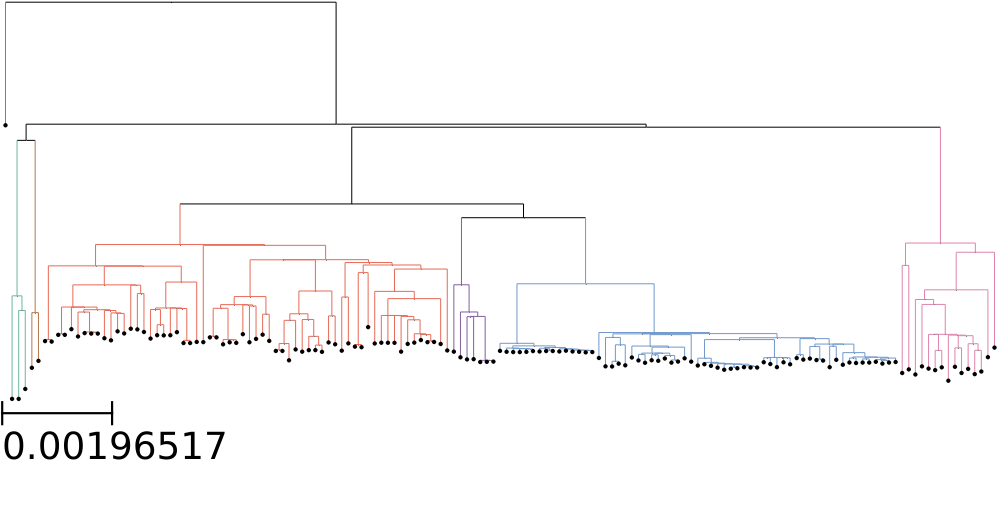

In [68]:
IQ_Tree.render("%%inline", w = 1000, tree_style = ts_IQ)

In [69]:
MG_SVVCF_Mod_DF.head()

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
BubbleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BubbleRegion_1,NC_000962.3,1533,.,N,<CNV>,30,PASS,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=...,GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,*,[*],BubbleRegion_1,s1,s2,[],0
BubbleRegion_2,NC_000962.3,1591,.,N,<CNV>,30,PASS,NS=88;NA=1;ALEN=61;AC=88;VS=>s2;VE=>s5;AWALK=>...,GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,>s3>s4,[>s3>s4],BubbleRegion_2,s2,s5,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",11
BubbleRegion_3,NC_000962.3,13622,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,1358;AC=151,1;VS=>s5;VE=>s6...",GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,"*,>s2744","[*, >s2744]",BubbleRegion_3,s5,s6,[s2744],1
BubbleRegion_4,NC_000962.3,26469,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=1876,42;AC=151,1;VS=>s6;VE=>s...",GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,">s7,>s2247","[>s7, >s2247]",BubbleRegion_4,s6,s8,"[s2247, s7]",2
BubbleRegion_5,NC_000962.3,28887,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,87;AC=150,2;VS=>s8;VE=>s9;A...",GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,"*,>s2823","[*, >s2823]",BubbleRegion_5,s8,s9,[s2823],1


In [70]:
MG_SVVCF_Mod_DF.query("Pos == 1761789")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
BubbleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BubbleRegion_193,NC_000962.3,1761789,.,N,<CNV>,30,PASS,"NS=152;NA=3;ALEN=0,2153,3511;AC=131,20,1;VS=>s...",GT:GT0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,"*,>s1800>s1801,>s1800>s2706>s1801","[*, >s1800>s1801, >s1800>s2706>s1801]",BubbleRegion_193,s575,s576,"[s1800, s2706, s1801]",3


In [71]:
MG_SVVCF_Mod_Tbd1_DF = MG_SVVCF_Mod_DF.query("BubbleID == 'BubbleRegion_193'")

In [72]:
MG_SVVCF_Mod_Tbd1_DF  

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
BubbleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BubbleRegion_193,NC_000962.3,1761789,.,N,<CNV>,30,PASS,"NS=152;NA=3;ALEN=0,2153,3511;AC=131,20,1;VS=>s...",GT:GT0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,"*,>s1800>s1801,>s1800>s2706>s1801","[*, >s1800>s1801, >s1800>s2706>s1801]",BubbleRegion_193,s575,s576,"[s1800, s2706, s1801]",3


In [73]:
dictOf_Tbd1_PresAbs = {}

for i, row in MG_SVVCF_Mod_Tbd1_DF.iterrows():
    
    i_BubbleID = row["BubbleID"]
    print(i_BubbleID)
    for sampleID in SampleIDs_151CI_SOI:
        
        Sample_Allele = row[sampleID] #.values[0]
        
        if Sample_Allele == 0:
            dictOf_Tbd1_PresAbs[sampleID] = 0
        else:
            dictOf_Tbd1_PresAbs[sampleID] = 1

    #print(row)
    #if i >= 0: break

BubbleRegion_193


In [74]:
dictOf_Tbd1_MultiAllele = {}

for i, row in MG_SVVCF_Mod_Tbd1_DF.iterrows():
    for sampleID in SampleIDs_151CI_SOI:
        
        Sample_Allele = row[sampleID] #.values[0]
        
        dictOf_Tbd1_MultiAllele[sampleID] = Sample_Allele
        
        # if Sample_Allele == 0: dictOf_Tbd1_PresAbs[sampleID] = 0
        # else: dictOf_Tbd1_PresAbs[sampleID] = Sample_Allele

    #print(row)
    #if i >= 0: break

In [75]:
dictOf_Tbd1_MultiAllele['N0072']

1

## Plot Allele presence/absence of TbD1 across Mtb phylogeny

In [76]:
#def plotRecombOnPhylo(i_ParentNode_Name, i_ChildNode_Name, input_Tree):
def labelLeafsByPresAbs_SV(nodeToPresAbs_Dict, input_Tree):

    input_Tree_Labeled = input_Tree.copy()
        
    # Draws nodes as small red spheres of diameter equal to 10 pixels
    #i_nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style
    #i_nstyle["shape"] = "sphere"
    #i_nstyle["size"] = 50
    #i_nstyle["fgcolor"] = "darkred" #"darkred"
    
    #for n in i_Gubbins_T.get_leaves():
    for n in input_Tree_Labeled.traverse():
        
        Node_NumEvents = nodeToPresAbs_Dict.get(n.name, 0)
    
        nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style

        nstyle["size"] = 1 + Node_NumEvents

        if Node_NumEvents >= 7:
            nstyle["fgcolor"] = "green"
            
        if Node_NumEvents == 6:
            nstyle["fgcolor"] = "yellow"
            
        if Node_NumEvents == 5:
            nstyle["fgcolor"] = "pink"
            
        if Node_NumEvents == 4:
            nstyle["fgcolor"] = "purple"
            
        if Node_NumEvents == 3:
            nstyle["fgcolor"] = "orange"
            
        if Node_NumEvents == 2:
            nstyle["fgcolor"] = "blue"
            
        if Node_NumEvents == 1:
            nstyle["fgcolor"] = "red"
        if Node_NumEvents == 0:
            nstyle["fgcolor"] = "black"   
        
        n.set_style(nstyle)
        
        Node_PrimaryLin = node_To_PrimaryLin_Dict.get(n.name, "None")
        n.img_style["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        n.img_style["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        
        
        #n.img_style["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        #n.img_style["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
            
    return input_Tree_Labeled



#def plotRecombOnPhylo(i_ParentNode_Name, i_ChildNode_Name, input_Tree):
def labelLeafsByPresAbs_SV_0to2(nodeToPresAbs_Dict, input_Tree):

    input_Tree_Labeled = input_Tree.copy()
        
    # Draws nodes as small red spheres of diameter equal to 10 pixels
    #i_nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style
    #i_nstyle["shape"] = "sphere"
    #i_nstyle["size"] = 50
    #i_nstyle["fgcolor"] = "darkred" #"darkred"
    
    #for n in i_Gubbins_T.get_leaves():
    for n in input_Tree_Labeled.traverse():
        
        Node_Allele = nodeToPresAbs_Dict.get(n.name, 0)
    
        nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style

        #nstyle["size"] = 1 + Node_NumEvents
        nstyle["size"] = 0
        nstyle["fgcolor"] = "black"   
        if n.is_leaf():
            if Node_Allele >= 2:
                nstyle["fgcolor"] = "blue"
                nstyle["size"] = 5
            if Node_Allele == 1:
                nstyle["fgcolor"] = "red"
                nstyle["size"] = 5

            if Node_Allele == 0:
                nstyle["fgcolor"] = "black"   
                nstyle["size"] = 1
            
        n.set_style(nstyle)
        
        Node_PrimaryLin = node_To_PrimaryLin_Dict.get(n.name, "None")
        n.img_style["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        n.img_style["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        
        
        #n.img_style["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        #n.img_style["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
            
    return input_Tree_Labeled


ts_3 = ETE.TreeStyle()
ts_3.show_leaf_name = False
ts_3.show_branch_length = False
ts_3.show_branch_support = False
ts_3.show_scale = True #True
ts_3.branch_vertical_margin = 2
#ts_3.layout_fn = Mtb_ColorBranchByLineage_Layout
ts_3.rotation = 90
        

In [77]:
#Tree_NumEvents_Labeled = labelLeafsByPresAbs_SV(dictOf_Tbd1_PresAbs, IQ_Tree)
#Tree_NumEvents_Labeled.render("%%inline", w = 1200, tree_style = ts_3) 

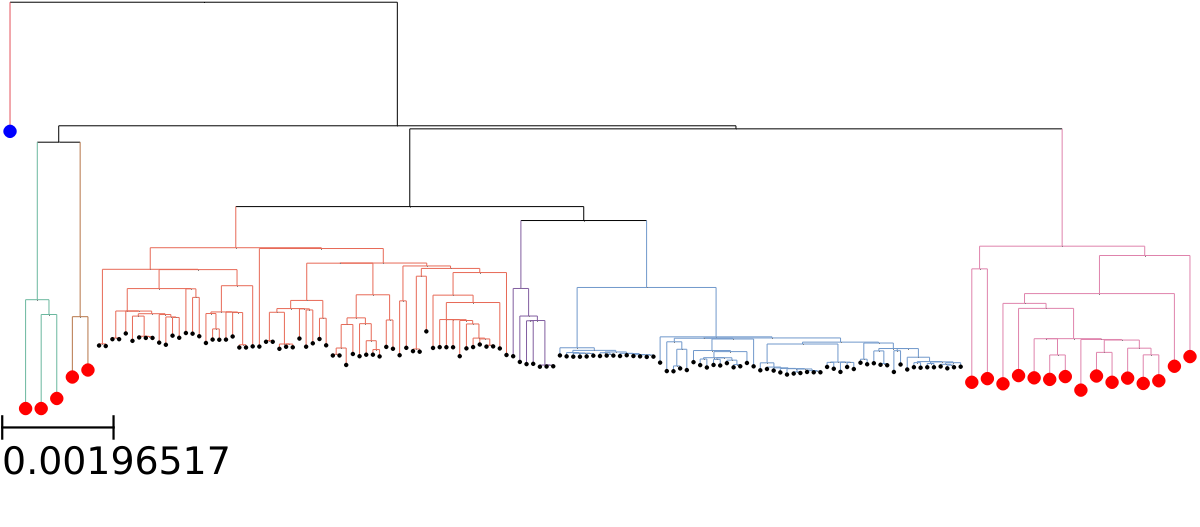

In [82]:
Tree_NumEvents_Labeled = labelLeafsByPresAbs_SV_0to2(dictOf_Tbd1_MultiAllele, IQ_Tree)

Tree_NumEvents_Labeled.render("%%inline", w = 1200, tree_style = ts_3)

In [83]:
Z = Tree_NumEvents_Labeled.render("Results2_Plots/SuppFig.TbD1.VizOnPhylo.151CI.png", w = 1000, tree_style = ts_3)   
Z = Tree_NumEvents_Labeled.render("Results2_Plots/SuppFig.TbD1.VizOnPhylo.151CI.svg", w = 1000, tree_style = ts_3)  

In [ ]:
Tree_NumEvents_Labeled = labelLeafsByPresAbs_SV_0to2(dictOf_Tbd1_MultiAllele, IQ_Tree)

Tree_NumEvents_Labeled.render("%%inline", w = 1200, tree_style = ts_3)

In [80]:
STOP!

SyntaxError: invalid syntax (<ipython-input-80-3bfd59f24194>, line 1)

## Make a dictionary of SV Alleles per bubble

In [585]:
MG_SVVCF_Mod_DF.head(4)

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
BubbleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BubbleRegion_1,NC_000962.3,1533,.,N,<CNV>,30,PASS,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=...,GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,*,[*],BubbleRegion_1,s1,s2,[],0
BubbleRegion_2,NC_000962.3,1591,.,N,<CNV>,30,PASS,NS=88;NA=1;ALEN=61;AC=88;VS=>s2;VE=>s5;AWALK=>...,GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,>s3>s4,[>s3>s4],BubbleRegion_2,s2,s5,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",11
BubbleRegion_3,NC_000962.3,13622,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,1358;AC=151,1;VS=>s5;VE=>s6...",GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,"*,>s2744","[*, >s2744]",BubbleRegion_3,s5,s6,[s2744],1
BubbleRegion_4,NC_000962.3,26469,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=1876,42;AC=151,1;VS=>s6;VE=>s...",GT:GT0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,">s7,>s2247","[>s7, >s2247]",BubbleRegion_4,s6,s8,"[s2247, s7]",2


In [588]:
dictOf_SVAlleles_PerBubble = {}

for i, row in MG_SVVCF_Mod_DF.iterrows():
    
    BubbleID = row["BubbleID"]
    
    SVAllele_Dict = row.T[SampleIDs_151CI_SOI].to_dict()
    
    dictOf_SVAlleles_PerBubble[BubbleID] = SVAllele_Dict
    

In [589]:
list(dictOf_SVAlleles_PerBubble.keys())[:10]

['BubbleRegion_1',
 'BubbleRegion_2',
 'BubbleRegion_3',
 'BubbleRegion_4',
 'BubbleRegion_5',
 'BubbleRegion_6',
 'BubbleRegion_7',
 'BubbleRegion_8',
 'BubbleRegion_9',
 'BubbleRegion_10']

In [591]:
len(list(dictOf_SVAlleles_PerBubble.keys()))

535

In [593]:
dictOf_SVAlleles_PerBubble['BubbleRegion_1']["N0072"]

0

# Read in processed k-mer analysis of ALL NODEs

In [93]:
PangenomeAnalysis_Dir = "../../Data/MtbPangenomeAnalysis_SetV3"

MG_AvA_Node_KmerAnalysis_TSV = f"{PangenomeAnalysis_Dir}/Minigraph.NodeAnalysis.151CI.AllVsAll.KmerAnalysis.V1.tsv.gz"     

MG_Node_KmerAnalysis_TSV = f"{PangenomeAnalysis_Dir}/Minigraph.NodeAnalysis.151CI.KmerAnalysis.VsAllOtherNodes.V4.tsv"


## Parse node-level analysis DF

In [94]:
MG_NodeAnalysis_DF = pd.read_csv(MG_Node_KmerAnalysis_TSV, sep = "\t" )

MG_NodeAnalysis_DF["BubbleID"] = MG_NodeAnalysis_DF["NodeID"].map(NodeID_ToBubbleID_Dict)
MG_NodeAnalysis_DF["BubbleID"] = MG_NodeAnalysis_DF["BubbleID"].fillna("None")


In [95]:
MG_NodeAnalysis_DF["IsSVNode"].value_counts()

True     2601
False     536
Name: IsSVNode, dtype: int64

In [96]:
MG_NodeAnalysis_DF.head()

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiAllOtherNodes,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID
0,s1,1533,1.0,0.0,0.000000,0.0,False,None
1,s2,58,1.0,0.0,0.000000,0.0,False,None
2,s3,56,1.0,0.0,0.961538,0.0,True,BubbleRegion_2
3,s4,5,0.0,0.0,0.000000,0.0,True,BubbleRegion_2
4,s5,11970,1.0,0.0,0.000000,0.0,False,None


In [97]:
MG_NodeAnalysis_DF.query("NodeID == 's7'")

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiAllOtherNodes,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID
6,s7,1876,1.0,0.0,0.006501,0.0,True,BubbleRegion_4


In [98]:
MG_NodeAnalysis_DF[ MG_NodeAnalysis_DF["NodeID"].isin(["s940", "s941", "s942"]) ]

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiAllOtherNodes,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID
939,s940,1786,1.0,0.0,0.0,0.0,False,None
940,s941,1280,1.0,0.0,0.0,0.0,False,None
941,s942,644,1.0,0.0,0.0,0.0,False,None


### How many total nodes are there? 

In [99]:
MG_NodeAnalysis_DF.shape

(3137, 8)

### What is the cumlative lenth of the graph?

In [100]:
MG_NodeAnalysis_DF["SeqLength"].sum()

5210226

## Parse all vs all comparison

In [101]:
AvA_Nodes_Trim_DF = pd.read_csv(MG_AvA_Node_KmerAnalysis_TSV, sep = "\t" )
AvA_Nodes_Trim_DF.shape

(120200, 6)

In [102]:
AvA_Nodes_Trim_DF.head()

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,JaccardSim,JaccardContain
0,s3,s2977,56,61,0.781250,0.961538
1,s7,s2542,1876,42,0.006501,0.006501
2,s8,s2824,542,87,0.096339,0.097656
3,s10,s2029,4163,48,0.002173,0.002178
4,s10,s2031,4163,51,0.002171,0.002178


In [ ]:
#STOP!

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [103]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

#MtbWGA_SMK_Pipeline_OutputDir = WGA_SMK_Outputs_Dir + "/220427_WGA158CI_V1"
WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"
MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir

## Define paths to all Assembly FAs + BAKTA Annotations (Short + Long read ASMs)

In [104]:
listOfSample_Tags = WGA151CI_SampleIDs

target_SMK_OutputDir = MtbWGA_SMK_Pipeline_OutputDir

SampleTag_ToPaths_Dict = {}

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = target_SMK_OutputDir + "/AsmAnalysis/" + SampleID
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"
    
    # LR Bakta Anno Files
    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    
    i_LRAsm_Bakta_GFF = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3"
    i_LRAsm_Bakta_GBFF = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff"
    i_LRAsm_Bakta_FAA = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa"
    i_LRAsm_Bakta_FFN = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn"
    i_LRAsm_Bakta_FNA = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna"
    i_LRAsm_Bakta_TXT = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt"

    
    MM2_AsmToRef_Output_Dir = sample_Asm_OutputDir + "/VariantCallingVersusH37Rv/MM2_AsmToH37rv"
    MM2_AsmToH37Rv_BAM = f"{MM2_AsmToRef_Output_Dir}/{SampleID}.mm2.AsmToH37Rv.bam"

    dictOfPaths_Temp = {}
    dictOfPaths_Temp["LRAsm_Bakta_GFF"] = i_LRAsm_Bakta_GFF  
    dictOfPaths_Temp["LRAsm_Bakta_GBFF"] = i_LRAsm_Bakta_GBFF
    dictOfPaths_Temp["LRAsm_Bakta_FAA"] = i_LRAsm_Bakta_FAA    
    dictOfPaths_Temp["LRAsm_Bakta_FFN"] = i_LRAsm_Bakta_FFN    
    dictOfPaths_Temp["LRAsm_Bakta_FNA"] = i_LRAsm_Bakta_FNA  
    dictOfPaths_Temp["LRAsm_Bakta_TXT"] = i_LRAsm_Bakta_TXT 

    dictOfPaths_Temp["MM2_AsmToH37Rv_BAM"] = MM2_AsmToH37Rv_BAM    
    
    SampleTag_ToPaths_Dict[SampleID] = dictOfPaths_Temp



# Viz of genome annotations

## Import and setup DNA Features Viewer (For plotting H37rv genome annotations)

In [105]:
from dna_features_viewer import GraphicFeature, GraphicRecord, CircularGraphicRecord, BiopythonTranslator
from Bio import SeqIO

In [106]:
BiopythonTranslator.label_fields = ['gene', 'label', 'source', 'locus_tag', 'note', 'gene', 'product']
BiopythonTranslator.ignored_features_types = ["source", "gene"]

In [107]:
H37rv_Ref_GBK_PATH = "/n/data1/hms/dbmi/farhat/mm774/References/GCF_000195955.2_ASM19595v2_genomic.gbk"

In [108]:
records = list(SeqIO.parse(H37rv_Ref_GBK_PATH, "genbank"))
len(records)

1

In [109]:
Mtb_H37rv_SeqIO_Record = records[0]
Mtb_H37rv_Graphic_Record = BiopythonTranslator().translate_record(Mtb_H37rv_SeqIO_Record)

In [110]:
#Mtb_H37rv_SeqIO_Record[2268721 - 500: 2268721 - 500]

### Test DNA Features Viewer's plotting function

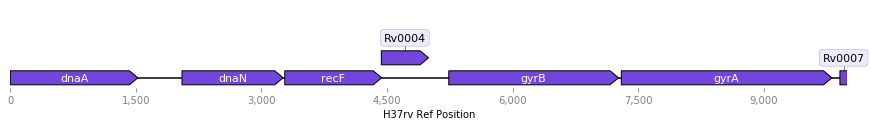

In [111]:
fig, axs = plt.subplots(1, 1, figsize=(15, 1.5), sharex=True)

Start_Coord = 0
End_Coord = 10000
Mtb_H37rv_Graphic_Record_cropped = Mtb_H37rv_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Mtb_H37rv_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.set(xlabel='H37rv Ref Position')
plt.show()

In [112]:
H37rv_Bakta_GBK_PATH = "/n/data1/hms/dbmi/farhat/mm774/Projects/MtbPangenomeComp/MtbPangenomeExploration/Data/230302.PGAPvsBakta.Plots/H37Rv/Bakta_annotation_H37Rv/H37Rv.gbff"       



In [113]:
Rv_Bakta_records = list(SeqIO.parse(H37rv_Bakta_GBK_PATH, "genbank"))
len(Rv_Bakta_records)

1

In [114]:
Rv_Bakta_SeqIO_Record = Rv_Bakta_records[0]
Rv_Bakta_Graphic_Record = BiopythonTranslator().translate_record(Rv_Bakta_SeqIO_Record)

In [115]:
#Mtb_H37rv_SeqIO_Record[2268721 - 500: 2268721 - 500]

### Test DNA Features Viewer's plotting function

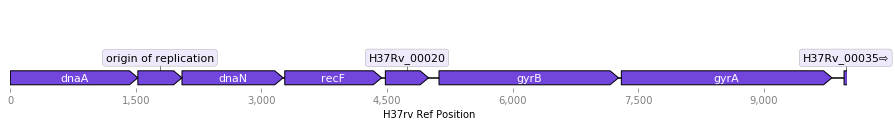

In [116]:
fig, axs = plt.subplots(1, 1, figsize=(15, 1.5), sharex=True)

Start_Coord = 0
End_Coord = 10000
Rv_Bakta_Graphic_Record_cropped = Rv_Bakta_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Rv_Bakta_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.set(xlabel='H37rv Ref Position')
plt.show()

In [117]:
H37rv_PGAP_GBK_PATH = "/n/data1/hms/dbmi/farhat/mm774/Projects/MtbPangenomeComp/MtbPangenomeExploration/Data/230302.PGAPvsBakta.Plots/H37Rv/PGAP_annotation_H37Rv/annot.gbk"       



In [118]:
Rv_PGAP_records = list(SeqIO.parse(H37rv_PGAP_GBK_PATH, "genbank"))
len(Rv_PGAP_records)

1

In [119]:
Rv_PGAP_SeqIO_Record = Rv_PGAP_records[0]
Rv_PGAP_Graphic_Record = BiopythonTranslator().translate_record(Rv_PGAP_SeqIO_Record)

In [120]:
#Mtb_H37rv_SeqIO_Record[2268721 - 500: 2268721 - 500]

### Test DNA Features Viewer's plotting function

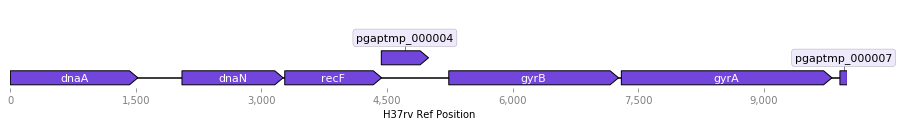

In [121]:
fig, axs = plt.subplots(1, 1, figsize=(15, 1.5), sharex=True)

Start_Coord = 0
End_Coord = 10000
Rv_PGAP_Graphic_Record_cropped = Rv_PGAP_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Rv_PGAP_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.set(xlabel='H37rv Ref Position')
plt.show()

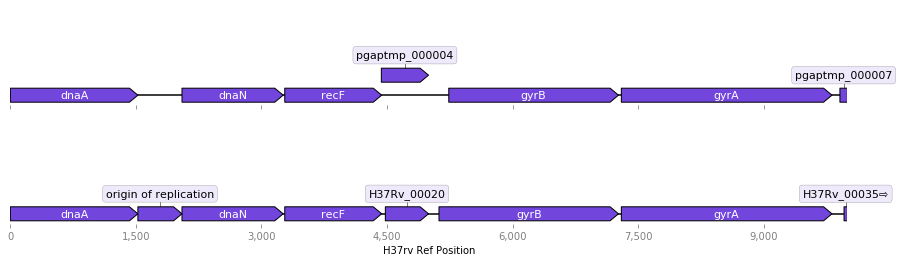

In [122]:
fig, axs = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

Start_Coord = 0
End_Coord = 10000
Rv_PGAP_Graphic_Record_cropped = Rv_PGAP_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Rv_PGAP_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs[0], plot_sequence = False)

Rv_Bakta_Graphic_Record_cropped = Rv_Bakta_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Rv_Bakta_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs[1], plot_sequence = False)


axs[1].set(xlabel='H37rv Ref Position')
plt.show()

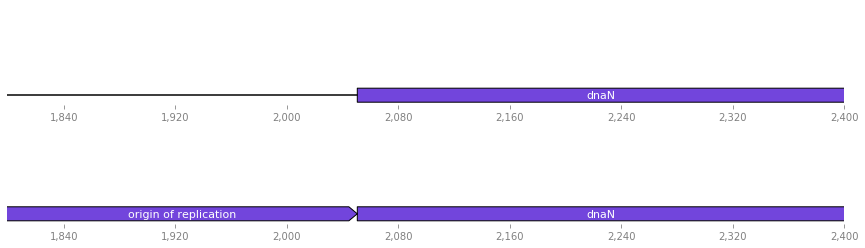

In [123]:
fig, axs = plt.subplots(2, 1, figsize=(15, 4), sharex=False)

Start_Coord = 1800
End_Coord = 2400
Rv_PGAP_Graphic_Record_cropped = Rv_PGAP_Graphic_Record.crop((Start_Coord, End_Coord))
Rv_PGAP_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs[0], plot_sequence = False)

Rv_Bakta_Graphic_Record_cropped = Rv_Bakta_Graphic_Record.crop((Start_Coord, End_Coord ))
Rv_Bakta_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs[1], plot_sequence = False)


#axs[1].set(xlabel='H37rv Ref Position')
plt.show()

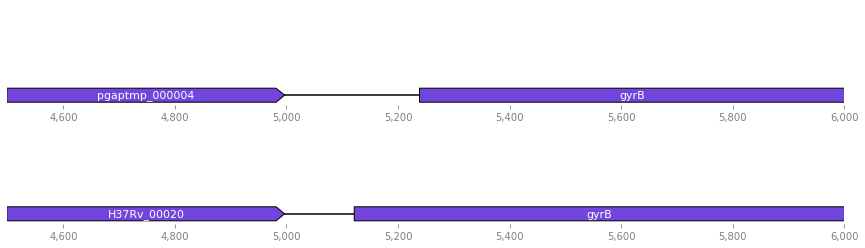

In [124]:
fig, axs = plt.subplots(2, 1, figsize=(15, 4), sharex=False)

Start_Coord = 4500
End_Coord = 6000
Rv_PGAP_Graphic_Record_cropped = Rv_PGAP_Graphic_Record.crop((Start_Coord, End_Coord))
Rv_PGAP_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs[0], plot_sequence = False)

Rv_Bakta_Graphic_Record_cropped = Rv_Bakta_Graphic_Record.crop((Start_Coord, End_Coord ))
Rv_Bakta_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs[1], plot_sequence = False)


#axs[1].set(xlabel='H37rv Ref Position')
plt.show()

# Let's viz Tbd1 across some genomes

In [125]:
MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_196'")

,Chr,Start,End,Info,FORMAT,NA,BubbleNum,BubbleID,NC_000962.3,mada_1-40,mada_1-44,mada_2-46,mada_107,mada_1-1,mada_1-51,mada_1-39,mada_122,mada_1-36,mada_117,mada_118,mada_1-10,N0072,N0153,R27252,R23887,R30078,R28012,R27657,R30234,R31095,R28703,R24120,MFS-3,R36431,R29816,MFS-42,DNA096,DNA114,DNA028,706-05,DNA089,9050-05,3003-06,702-06,DNA019_Vash,696-05,8651-04,DNA091,4549-04,ARR1960,AZE_02_041,ZRB10578980,8129-04,DNA075,AZE_02_067,R30215,R25048,MFS-59,MFS-58,R29598,R24100,R28581,MFS-173,MFS-51,MFS-52,MFS-54,N0145,mada_1-11,N0155,mada_115,mada_2-42,M0003941_3,R37765,18_0621851,R27937,R22601,R18040,R18043,R27725,R26791,R20574,R20260,R21408,R23146,R28980,R26778,R32929,R30420,R21893,QC-9,QC-5,QC-3,N0004,mada_1-30,N0054,N1274,mada_1-53,mada_2-53,mada_1-50,mada_2-1,R23571,mada_1-2,mada_123,8644-04,mada_128,mada_1-12,mada_1-15,DNA120,mada_1-38,01_R1134,mada_126,mada_120,DNA124,M0016737_0,DNA054,mada_112,mada_124,mada_103,MFS-60,MFS-61,MFS-181,02_R1896,mada_2-25,DNA020,M0011368_9,01_R1430,AZE_02_042,DNA086,DNA182,02_R1179,QC-6,QC-1,QC-7,M0010874_7,M0016395_7,R15311,DNA044,M0014888_3,mada_151,DNA188,mada_105,QC-8,QC-10,QC-4,mada_129,02_R1708,02_R0894,mada_139,DNA019_Rose,MT_0080,mada_102,R21839,R21363,R21770,R30396,R20896,mada_1-32,MFS-56,M0017522_5,mada_2-31,mada_1-41,N1272,N1176,N0091,N1202,N1177,RW-TB008
195,NC_000962.3,1761789,1761789,"NS=159;NA=3;ALEN=0,2153,3511;AC=137,21,1;VS=>s...",GT:CSTRAND:CTG:CS:CE,3,196,BubbleRegion_196,0:+:NC_000962.3:1761780:1761791,1:+:mada_1-40:1762086:1764250,1:+:mada_1-44:1759552:1761716,1:+:mada_2-46:1753972:1756136,1:+:mada_107:1763524:1765688,1:+:mada_1-1:1762651:1764815,1:+:mada_1-51:1762515:1764679,1:+:mada_1-39:1761859:1764023,1:+:mada_122:1762340:1764504,1:+:mada_1-36:1762284:1764449,1:+:mada_117:1758846:1761010,1:+:mada_118:1763387:1765551,1:+:mada_1-10:1764294:1766458,1:+:N0072:1765264:1767428,1:+:N0153:1761674:1763838,1:+:R27252:1763229:1765393,1:+:R23887:1772892:1775056,0:+:R30078:1766390:1766401,0:+:R28012:1766387:1766398,0:+:R27657:1766392:1766403,0:+:R30234:1766372:1766383,0:+:R31095:1766374:1766385,0:+:R28703:1766426:1766437,0:+:R24120:1766416:1766427,0:+:MFS-3:1767760:1767771,0:+:R36431:1766402:1766413,0:+:R29816:1766418:1766429,0:+:MFS-42:1769021:1769032,0:+:DNA096:1544277:1544288,0:+:DNA114:1544276:1544287,0:+:DNA028:1544359:1544370,0:+:706-05:1545736:1545747,0:+:DNA089:1544264:1544275,0:+:9050-05:1763459:1763470,0:+:3003-06:1763476:1763487,0:+:702-06:1763483:1763494,0:+:DNA019_Vash:1763416:1763427,0:+:696-05:1763483:1763494,0:+:8651-04:1763402:1763413,0:+:DNA091:1763409:1763420,0:+:4549-04:1764869:1764880,0:+:ARR1960:1763409:1763420,0:+:AZE_02_041:1764935:1764946,0:+:ZRB10578980:1764935:1764946,0:+:8129-04:1767678:1767689,0:+:DNA075:1764929:1764940,0:+:AZE_02_067:1766885:1766896,0:+:R30215:1764956:1764967,0:+:R25048:1759623:1759634,0:+:MFS-59:1768804:1768815,0:+:MFS-58:1768747:1768758,0:+:R29598:1768828:1768839,0:+:R24100:1768831:1768842,0:+:R28581:1768838:1768849,0:+:MFS-173:1768777:1768788,0:+:MFS-51:1768768:1768779,0:+:MFS-52:1768810:1768821,0:+:MFS-54:1768813:1768824,0:+:N0145:1767523:1767534,0:+:mada_1-11:1767448:1767459,0:+:N0155:1765198:1765209,0:+:mada_115:1766655:1766666,0:+:mada_2-42:1766455:1766466,0:+:M0003941_3:1766684:1766695,0:+:R37765:1764212:1764223,0:+:18_0621851:1766054:1766065,0:+:R27937:1764232:1764243,0:+:R22601:1764244:1764255,0:+:R18040:1764231:1764242,0:+:R18043:1764247:1764258,0:+:R27725:1764245:1764256,0:+:R26791:1764241:1764252,0:+:R20574:1764250:1764261,0:+:R20260:1764245:1764256,0:+:R21408:1764242:1764253,0:+:R23146:1764247:1764258,0:+:R28980:1761060:1761071,0:+:R26778:1764248:1764259,0:+:R32929:1765901:1765912,0:+:R30420:1764288:1764299,0:+:R21893:1763037:1763048,0:+:QC-9:1768467:1768495,0:+:QC-5:1768472:1768500,0:+:QC-3:1768475:1768503,0:+:N0004:1768053:1768081,0:+:mada_1-30:1779132:1779160,0:+:N0054:1771882:1771910,0:+:N1274:1768873:1768884,0:+:mada_1-53:1760511:1760522,0:+:mada_2-53:1760555:1760566,0:+:mada_1-50:1760555:1760566,0:+:mada_2-1:1760578

In [126]:
i_Bakta_GBFF_PATH = SampleTag_ToPaths_Dict["N0072"]["LRAsm_Bakta_GBFF"]

i_records = list(SeqIO.parse(i_Bakta_GBFF_PATH, "genbank"))
#print(sampleID, "- # of record =", len(i_records) )

i_Mtb_SeqIO_Record = i_records[0]
i_Mtb_Graphic_Record = BiopythonTranslator().translate_record(i_Mtb_SeqIO_Record)

N0072_Mtb_Graphic_Record = i_Mtb_Graphic_Record


In [127]:
i_Bakta_GBFF_PATH = SampleTag_ToPaths_Dict["RW-TB008"]["LRAsm_Bakta_GBFF"]

i_records = list(SeqIO.parse(i_Bakta_GBFF_PATH, "genbank"))
#print(sampleID, "- # of record =", len(i_records) )

i_Mtb_SeqIO_Record = i_records[0]
i_Mtb_Graphic_Record = BiopythonTranslator().translate_record(i_Mtb_SeqIO_Record)

RWTB008_Mtb_Graphic_Record = i_Mtb_Graphic_Record


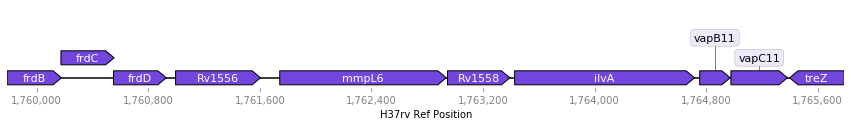

In [128]:
fig, axs = plt.subplots(1, 1, figsize=(15, 1.5), sharex=True)

Start_Coord = 1761789 - 2000
End_Coord = 1761789 + 4000
Mtb_H37rv_Graphic_Record_cropped = Mtb_H37rv_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Mtb_H37rv_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.set(xlabel='H37rv Ref Position')
plt.show()

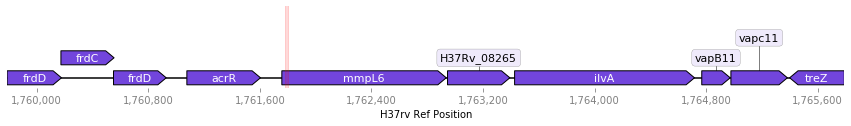

In [129]:
fig, axs = plt.subplots(1, 1, figsize=(15, 1.5), sharex=True)

Start_Coord = 1761789 - 2000
End_Coord = 1761789 + 4000
Rv_Bakta_Graphic_Record_cropped = Rv_Bakta_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Rv_Bakta_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.fill_between((1761789- 10, 1761789 + 10), +1000, -1000, alpha=0.15, color = "red")

axs.set(xlabel='H37rv Ref Position')
plt.show()

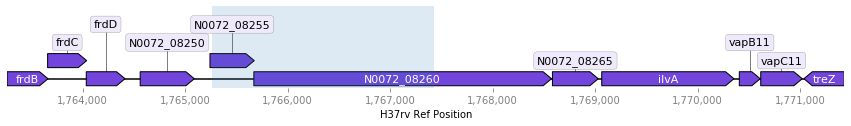

In [130]:
fig, axs = plt.subplots(1, 1, figsize=(15, 1.5), sharex=True)

Start_Coord = 1765264 - 2000
End_Coord = 1767428 + 4000
Mtb_H37rv_Graphic_Record_cropped = N0072_Mtb_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Mtb_H37rv_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.fill_between((1765264, 1767428), +1000, -1000, alpha=0.15)


axs.set(xlabel='H37rv Ref Position')
plt.show()

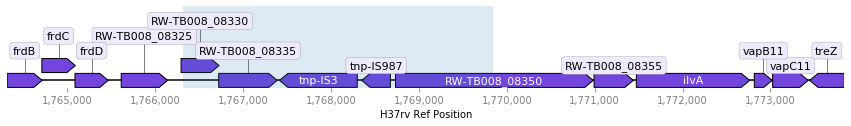

In [131]:
fig, axs = plt.subplots(1, 1, figsize=(15, 1.5), sharex=True)

Start_Coord = 1766316 - 2000
End_Coord = 1769838 + 4000
Mtb_H37rv_Graphic_Record_cropped = RWTB008_Mtb_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Mtb_H37rv_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.fill_between((1766316, 1769838), +1000, -1000, alpha=0.15)


axs.set(xlabel='H37rv Ref Position')
plt.show()

In [132]:
MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_196'")

,Chr,Start,End,Info,FORMAT,NA,BubbleNum,BubbleID,NC_000962.3,mada_1-40,mada_1-44,mada_2-46,mada_107,mada_1-1,mada_1-51,mada_1-39,mada_122,mada_1-36,mada_117,mada_118,mada_1-10,N0072,N0153,R27252,R23887,R30078,R28012,R27657,R30234,R31095,R28703,R24120,MFS-3,R36431,R29816,MFS-42,DNA096,DNA114,DNA028,706-05,DNA089,9050-05,3003-06,702-06,DNA019_Vash,696-05,8651-04,DNA091,4549-04,ARR1960,AZE_02_041,ZRB10578980,8129-04,DNA075,AZE_02_067,R30215,R25048,MFS-59,MFS-58,R29598,R24100,R28581,MFS-173,MFS-51,MFS-52,MFS-54,N0145,mada_1-11,N0155,mada_115,mada_2-42,M0003941_3,R37765,18_0621851,R27937,R22601,R18040,R18043,R27725,R26791,R20574,R20260,R21408,R23146,R28980,R26778,R32929,R30420,R21893,QC-9,QC-5,QC-3,N0004,mada_1-30,N0054,N1274,mada_1-53,mada_2-53,mada_1-50,mada_2-1,R23571,mada_1-2,mada_123,8644-04,mada_128,mada_1-12,mada_1-15,DNA120,mada_1-38,01_R1134,mada_126,mada_120,DNA124,M0016737_0,DNA054,mada_112,mada_124,mada_103,MFS-60,MFS-61,MFS-181,02_R1896,mada_2-25,DNA020,M0011368_9,01_R1430,AZE_02_042,DNA086,DNA182,02_R1179,QC-6,QC-1,QC-7,M0010874_7,M0016395_7,R15311,DNA044,M0014888_3,mada_151,DNA188,mada_105,QC-8,QC-10,QC-4,mada_129,02_R1708,02_R0894,mada_139,DNA019_Rose,MT_0080,mada_102,R21839,R21363,R21770,R30396,R20896,mada_1-32,MFS-56,M0017522_5,mada_2-31,mada_1-41,N1272,N1176,N0091,N1202,N1177,RW-TB008
195,NC_000962.3,1761789,1761789,"NS=159;NA=3;ALEN=0,2153,3511;AC=137,21,1;VS=>s...",GT:CSTRAND:CTG:CS:CE,3,196,BubbleRegion_196,0:+:NC_000962.3:1761780:1761791,1:+:mada_1-40:1762086:1764250,1:+:mada_1-44:1759552:1761716,1:+:mada_2-46:1753972:1756136,1:+:mada_107:1763524:1765688,1:+:mada_1-1:1762651:1764815,1:+:mada_1-51:1762515:1764679,1:+:mada_1-39:1761859:1764023,1:+:mada_122:1762340:1764504,1:+:mada_1-36:1762284:1764449,1:+:mada_117:1758846:1761010,1:+:mada_118:1763387:1765551,1:+:mada_1-10:1764294:1766458,1:+:N0072:1765264:1767428,1:+:N0153:1761674:1763838,1:+:R27252:1763229:1765393,1:+:R23887:1772892:1775056,0:+:R30078:1766390:1766401,0:+:R28012:1766387:1766398,0:+:R27657:1766392:1766403,0:+:R30234:1766372:1766383,0:+:R31095:1766374:1766385,0:+:R28703:1766426:1766437,0:+:R24120:1766416:1766427,0:+:MFS-3:1767760:1767771,0:+:R36431:1766402:1766413,0:+:R29816:1766418:1766429,0:+:MFS-42:1769021:1769032,0:+:DNA096:1544277:1544288,0:+:DNA114:1544276:1544287,0:+:DNA028:1544359:1544370,0:+:706-05:1545736:1545747,0:+:DNA089:1544264:1544275,0:+:9050-05:1763459:1763470,0:+:3003-06:1763476:1763487,0:+:702-06:1763483:1763494,0:+:DNA019_Vash:1763416:1763427,0:+:696-05:1763483:1763494,0:+:8651-04:1763402:1763413,0:+:DNA091:1763409:1763420,0:+:4549-04:1764869:1764880,0:+:ARR1960:1763409:1763420,0:+:AZE_02_041:1764935:1764946,0:+:ZRB10578980:1764935:1764946,0:+:8129-04:1767678:1767689,0:+:DNA075:1764929:1764940,0:+:AZE_02_067:1766885:1766896,0:+:R30215:1764956:1764967,0:+:R25048:1759623:1759634,0:+:MFS-59:1768804:1768815,0:+:MFS-58:1768747:1768758,0:+:R29598:1768828:1768839,0:+:R24100:1768831:1768842,0:+:R28581:1768838:1768849,0:+:MFS-173:1768777:1768788,0:+:MFS-51:1768768:1768779,0:+:MFS-52:1768810:1768821,0:+:MFS-54:1768813:1768824,0:+:N0145:1767523:1767534,0:+:mada_1-11:1767448:1767459,0:+:N0155:1765198:1765209,0:+:mada_115:1766655:1766666,0:+:mada_2-42:1766455:1766466,0:+:M0003941_3:1766684:1766695,0:+:R37765:1764212:1764223,0:+:18_0621851:1766054:1766065,0:+:R27937:1764232:1764243,0:+:R22601:1764244:1764255,0:+:R18040:1764231:1764242,0:+:R18043:1764247:1764258,0:+:R27725:1764245:1764256,0:+:R26791:1764241:1764252,0:+:R20574:1764250:1764261,0:+:R20260:1764245:1764256,0:+:R21408:1764242:1764253,0:+:R23146:1764247:1764258,0:+:R28980:1761060:1761071,0:+:R26778:1764248:1764259,0:+:R32929:1765901:1765912,0:+:R30420:1764288:1764299,0:+:R21893:1763037:1763048,0:+:QC-9:1768467:1768495,0:+:QC-5:1768472:1768500,0:+:QC-3:1768475:1768503,0:+:N0004:1768053:1768081,0:+:mada_1-30:1779132:1779160,0:+:N0054:1771882:1771910,0:+:N1274:1768873:1768884,0:+:mada_1-53:1760511:1760522,0:+:mada_2-53:1760555:1760566,0:+:mada_1-50:1760555:1760566,0:+:mada_2-1:1760578

# Reread in genbank files to Seq Record

In [133]:
H37rv_Ref_GBK_PATH = "/n/data1/hms/dbmi/farhat/mm774/References/GCF_000195955.2_ASM19595v2_genomic.gbk"
Rv_NCBI_records = list(SeqIO.parse(H37rv_Ref_GBK_PATH, "genbank"))
Rv_NCBI_record = Rv_NCBI_records[0]
len(records)

1

In [134]:
H37rv_Bakta_GBK_PATH = "/n/data1/hms/dbmi/farhat/mm774/Projects/MtbPangenomeComp/MtbPangenomeExploration/Data/230302.PGAPvsBakta.Plots/H37Rv/Bakta_annotation_H37Rv/H37Rv.gbff"       
Rv_Bakta_records = list(SeqIO.parse(H37rv_Bakta_GBK_PATH, "genbank"))
Rv_Bakta_SeqIO_Record = Rv_Bakta_records[0]

In [135]:
i_Bakta_GBFF_PATH = SampleTag_ToPaths_Dict["N0072"]["LRAsm_Bakta_GBFF"]
i_records = list(SeqIO.parse(i_Bakta_GBFF_PATH, "genbank"))

N0072_Record = i_records[0]

In [136]:
i_Bakta_GBFF_PATH = SampleTag_ToPaths_Dict["N1202"]["LRAsm_Bakta_GBFF"]
i_records = list(SeqIO.parse(i_Bakta_GBFF_PATH, "genbank"))

N1202_Record = i_records[0]

In [137]:
i_Bakta_GBFF_PATH = SampleTag_ToPaths_Dict["RW-TB008"]["LRAsm_Bakta_GBFF"]
i_records = list(SeqIO.parse(i_Bakta_GBFF_PATH, "genbank"))

RWTB008_Record = i_records[0]

In [138]:
i_Bakta_GBFF_PATH = SampleTag_ToPaths_Dict["DNA044"]["LRAsm_Bakta_GBFF"]
i_records = list(SeqIO.parse(i_Bakta_GBFF_PATH, "genbank"))

DNA044_Record = i_records[0]

In [139]:
i_Bakta_GBFF_PATH = SampleTag_ToPaths_Dict["MFS-60"]["LRAsm_Bakta_GBFF"]
i_records = list(SeqIO.parse(i_Bakta_GBFF_PATH, "genbank"))

MFS60_Record = i_records[0]

In [140]:
i_Bakta_GBFF_PATH = SampleTag_ToPaths_Dict["R27252"]["LRAsm_Bakta_GBFF"]
i_records = list(SeqIO.parse(i_Bakta_GBFF_PATH, "genbank"))

R27252_Record = i_records[0]

In [141]:
Tbd1_GBK_Dir = "./Tbd1_Viz_Test1"
!mkdir $Tbd1_GBK_Dir

mkdir: cannot create directory ‘./Tbd1_Viz_Test1’: File exists


## Subset Rv NCBI Record for Tbd1!

In [142]:
Rv_NCBI_record.seq

Seq('TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGGTCGTCTCC...TCG')

In [143]:
Rv_NCBI_Tbd1 = Rv_NCBI_record[1761789 - 2000: 1761789 + 4000]
len(Rv_NCBI_Tbd1.seq)

6000

In [144]:
with open(f"{Tbd1_GBK_Dir}/Rv_NCBI_Tbd1_Rec.gb", "w") as output_handle:
    SeqIO.write(Rv_NCBI_Tbd1, output_handle, "genbank")

## Subset Rv Bakta Record for Tbd1!

In [145]:
Rv_Bakta_SeqIO_Record.seq

Seq('TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGGTCGTCTCC...TCG')

In [146]:
Rv_Bakta_Tbd1 = Rv_Bakta_SeqIO_Record[1761789 - 2000: 1761789 + 4000]
len(Rv_Bakta_Tbd1.seq)

6000

In [147]:
with open(f"{Tbd1_GBK_Dir}/Rv_Bakta_Tbd1_Rec.gb", "w") as output_handle:
    SeqIO.write(Rv_Bakta_Tbd1, output_handle, "genbank")

## Subset N0072 Bakta Record for Tbd1!

In [148]:
N0072_Tbd1 = N0072_Record[1765264 - 2000: 1767428 + 4000]
len(N0072_Tbd1.seq)

8164

In [149]:
with open(f"{Tbd1_GBK_Dir}/N0072_Tbd1_Rec.gb", "w") as output_handle:
    SeqIO.write(N0072_Tbd1, output_handle, "genbank")

## Subset RW-TB008 Bakta Record for Tbd1!

In [150]:
RWTB008_Tbd1 = RWTB008_Record[1766316 - 2000: 1769838 + 4000]
len(RWTB008_Tbd1.seq)

9522

In [151]:
with open(f"{Tbd1_GBK_Dir}/RWTB008_Tbd1_Rec.gb", "w") as output_handle:
    SeqIO.write(RWTB008_Tbd1, output_handle, "genbank")

In [152]:
!ls -1 $Tbd1_GBK_Dir/*.gb

./Tbd1_Viz_Test1/N0072_Tbd1_Rec.gb
./Tbd1_Viz_Test1/Rv_Bakta_RD_Rv2024c_Rec.gb
./Tbd1_Viz_Test1/Rv_Bakta_Tbd1_Rec.gb
./Tbd1_Viz_Test1/Rv_NCBI_RD_Rv2024c_Rec.gb
./Tbd1_Viz_Test1/Rv_NCBI_Tbd1_Rec.gb
./Tbd1_Viz_Test1/RWTB008_Tbd1_Rec.gb


## Run clinker to VIZ Tbd1 regions

In [57]:
#!clinker --help

In [154]:

Tbd1_Viz_HTML = f"{Tbd1_GBK_Dir}/clinkerviz.Tbd1.test1.html"

Rv_GBK = f"{Tbd1_GBK_Dir}/Rv_NCBI_Tbd1_Rec.gb"
Rv_2_GBK = f"{Tbd1_GBK_Dir}/Rv_Bakta_Tbd1_Rec.gb"
N0072_GBK = f"{Tbd1_GBK_Dir}/N0072_Tbd1_Rec.gb"
RWTB008_GBK = f"{Tbd1_GBK_Dir}/RWTB008_Tbd1_Rec.gb"

!clinker $Rv_GBK $Rv_2_GBK $N0072_GBK $RWTB008_GBK --identity 0.3 --use_file_order -p $Tbd1_Viz_HTML


[15:00:58] INFO - Starting clinker
[15:00:58] INFO - Parsing files:
[15:00:58] INFO -   Rv_NCBI_Tbd1_Rec.gb
[15:00:58] INFO -   Rv_Bakta_Tbd1_Rec.gb
[15:00:58] INFO -   N0072_Tbd1_Rec.gb
[15:00:58] INFO -   RWTB008_Tbd1_Rec.gb
[15:00:58] INFO - Starting cluster alignments
[15:00:58] INFO - Rv_NCBI_Tbd1_Rec vs Rv_Bakta_Tbd1_Rec
[15:00:58] INFO - Rv_NCBI_Tbd1_Rec vs N0072_Tbd1_Rec
[15:00:58] INFO - Rv_NCBI_Tbd1_Rec vs RWTB008_Tbd1_Rec
[15:00:58] INFO - Rv_Bakta_Tbd1_Rec vs N0072_Tbd1_Rec
[15:00:58] INFO - Rv_Bakta_Tbd1_Rec vs RWTB008_Tbd1_Rec
[15:00:58] INFO - N0072_Tbd1_Rec vs RWTB008_Tbd1_Rec
[15:00:59] INFO - Generating results summary...
Rv_NCBI_Tbd1_Rec vs Rv_Bakta_Tbd1_Rec
-------------------------------------
Query        Target                 Identity  Similarity
NP_216070.1  gnl|Bakta|H37Rv_08245  1.00      1.00      
NP_216071.1  gnl|Bakta|H37Rv_08250  1.00      1.00      
NP_216072.1  gnl|Bakta|H37Rv_08255  0.87      0.87      
NP_216073.1  gnl|Bakta|H37Rv_08260  0.99      0.

In [155]:

Tbd1_Viz_V2_HTML = f"{Tbd1_GBK_Dir}/clinkerviz.Tbd1.test2.html"

Rv_GBK = f"{Tbd1_GBK_Dir}/Rv_NCBI_Tbd1_Rec.gb"
Rv_2_GBK = f"{Tbd1_GBK_Dir}/Rv_Bakta_Tbd1_Rec.gb"
N0072_GBK = f"{Tbd1_GBK_Dir}/N0072_Tbd1_Rec.gb"
RWTB008_GBK = f"{Tbd1_GBK_Dir}/RWTB008_Tbd1_Rec.gb"

!clinker $Rv_2_GBK $N0072_GBK $RWTB008_GBK --identity 0.3 --use_file_order -p $Tbd1_Viz_V2_HTML


[15:01:00] INFO - Starting clinker
[15:01:00] INFO - Parsing files:
[15:01:00] INFO -   Rv_Bakta_Tbd1_Rec.gb
[15:01:00] INFO -   N0072_Tbd1_Rec.gb
[15:01:00] INFO -   RWTB008_Tbd1_Rec.gb
[15:01:00] INFO - Starting cluster alignments
[15:01:00] INFO - Rv_Bakta_Tbd1_Rec vs N0072_Tbd1_Rec
[15:01:00] INFO - Rv_Bakta_Tbd1_Rec vs RWTB008_Tbd1_Rec
[15:01:00] INFO - N0072_Tbd1_Rec vs RWTB008_Tbd1_Rec
[15:01:01] INFO - Generating results summary...
Rv_Bakta_Tbd1_Rec vs N0072_Tbd1_Rec
-----------------------------------
Query                  Target                 Identity  Similarity
gnl|Bakta|H37Rv_08245  gnl|Bakta|N0072_08240  0.99      0.99      
gnl|Bakta|H37Rv_08250  gnl|Bakta|N0072_08245  1.00      1.00      
gnl|Bakta|H37Rv_08255  gnl|Bakta|N0072_08250  1.00      1.00      
gnl|Bakta|H37Rv_08260  gnl|Bakta|N0072_08260  0.40      0.40      
gnl|Bakta|H37Rv_08265  gnl|Bakta|N0072_08265  1.00      1.00      
gnl|Bakta|H37Rv_08270  gnl|Bakta|N0072_08270  1.00      1.00      
gnl|Bakta|H37Rv

In [ ]:
STOP!!!

In [156]:
RD_Rv2024c_GBK_Dir = "./RD_Rv2024c_VizTest1"
!mkdir $RD_Rv2024c_GBK_Dir

mkdir: cannot create directory ‘./RD_Rv2024c_VizTest1’: File exists


## Subset Rv NCBI Record for RD_Rv2024c!

In [157]:
Rv_NCBI_record.seq

Seq('TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGGTCGTCTCC...TCG')

In [158]:
Rv_NCBI_RD_Rv2024c = Rv_NCBI_record[2268720 - 3500: 2268720 + 12500]
len(Rv_NCBI_RD_Rv2024c.seq)

16000

In [159]:
with open(f"{RD_Rv2024c_GBK_Dir}/Rv_NCBI_RD_Rv2024c_Rec.gb", "w") as output_handle:
    SeqIO.write(Rv_NCBI_RD_Rv2024c, output_handle, "genbank")

## Subset Rv Bakta Record for RD_Rv2024c!

In [160]:
Rv_Bakta_SeqIO_Record.seq

Seq('TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGGTCGTCTCC...TCG')

In [161]:
Rv_Bakta_RD_Rv2024c = Rv_Bakta_SeqIO_Record[2268720 - 3500: 2268720 + 12500]
len(Rv_Bakta_RD_Rv2024c.seq)

16000

In [162]:
with open(f"{RD_Rv2024c_GBK_Dir}/Rv_Bakta_RD_Rv2024c_Rec.gb", "w") as output_handle:
    SeqIO.write(Rv_Bakta_RD_Rv2024c, output_handle, "genbank")

## Subset N0072 Bakta Record for RD_Rv2024c!

In [163]:
N0072_RD_Rv2024c = N0072_Record[2285767 - 3500: 2285767 + 12500]
len(N0072_RD_Rv2024c.seq)

16000

In [164]:
with open(f"{RD_Rv2024c_GBK_Dir}/N0072_RD_Rv2024c_Rec.gb", "w") as output_handle:
    SeqIO.write(N0072_RD_Rv2024c, output_handle, "genbank")

## Subset N1202 Bakta Record for RD_Rv2024c!

In [165]:
N1202_RD_Rv2024c = N1202_Record[2261400 - 3500: 2261400 + 12500]
len(N1202_RD_Rv2024c.seq)

16000

In [166]:
with open(f"{RD_Rv2024c_GBK_Dir}/N1202_RD_Rv2024c_Rec.gb", "w") as output_handle:
    SeqIO.write(N1202_RD_Rv2024c, output_handle, "genbank")

## Subset DNA044 Bakta Record for RD_Rv2024c!

In [167]:
DNA044_RD_Rv2024c = DNA044_Record[2275042 - 3500: 2281409 + 12500]
len(DNA044_RD_Rv2024c.seq)

22367

In [168]:
with open(f"{RD_Rv2024c_GBK_Dir}/DNA044_RD_Rv2024c_Rec.gb", "w") as output_handle:
    SeqIO.write(DNA044_RD_Rv2024c, output_handle, "genbank")

## Subset R27252 Bakta Record for RD_Rv2024c!

In [169]:
R27252_RD_Rv2024c = R27252_Record[2285176 - 3500: 2291543 + 12500]
len(R27252_RD_Rv2024c.seq)

22367

In [170]:
with open(f"{RD_Rv2024c_GBK_Dir}/R27252_RD_Rv2024c_Rec.gb", "w") as output_handle:
    SeqIO.write(R27252_RD_Rv2024c, output_handle, "genbank")

In [171]:
# 5:+:R27252:2285176:2291543

### Look at output GBK files

In [172]:
!ls -1 $RD_Rv2024c_GBK_Dir

clinkerviz.RD_Rv2024c.test1.html
clinkerviz.RD_Rv2024c.test2.html
clinkerviz.RD_Rv2024c.test3.html
DNA044_RD_Rv2024c_Rec.gb
N0072_RD_Rv2024c_Rec.gb
N1202_RD_Rv2024c_Rec.gb
R27252_RD_Rv2024c_Rec.gb
Rv_Bakta_RD_Rv2024c_Rec.gb
Rv_NCBI_RD_Rv2024c_Rec.gb


## Run Clinker to Viz RD Rv2024c

In [173]:


RD_Rv2024c_Viz_HTML = f"{RD_Rv2024c_GBK_Dir}/clinkerviz.RD_Rv2024c.test1.html"


Rv_GBK = f"{RD_Rv2024c_GBK_Dir}/Rv_NCBI_RD_Rv2024c_Rec.gb"
Rv_2_GBK = f"{RD_Rv2024c_GBK_Dir}/Rv_Bakta_RD_Rv2024c_Rec.gb"
N0072_GBK = f"{RD_Rv2024c_GBK_Dir}/N0072_RD_Rv2024c_Rec.gb"
N1202_GBK = f"{RD_Rv2024c_GBK_Dir}/N1202_RD_Rv2024c_Rec.gb"

!clinker $Rv_GBK $Rv_2_GBK $N0072_GBK $N1202_GBK --use_file_order -p $RD_Rv2024c_Viz_HTML






[15:01:03] INFO - Starting clinker
[15:01:03] INFO - Parsing files:
[15:01:03] INFO -   Rv_NCBI_RD_Rv2024c_Rec.gb
[15:01:03] INFO -   Rv_Bakta_RD_Rv2024c_Rec.gb
[15:01:03] INFO -   N0072_RD_Rv2024c_Rec.gb
[15:01:03] INFO -   N1202_RD_Rv2024c_Rec.gb
[15:01:03] INFO - Starting cluster alignments
[15:01:03] INFO - Rv_NCBI_RD_Rv2024c_Rec vs Rv_Bakta_RD_Rv2024c_Rec
[15:01:03] INFO - Rv_NCBI_RD_Rv2024c_Rec vs N0072_RD_Rv2024c_Rec
[15:01:03] INFO - Rv_NCBI_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:03] INFO - Rv_Bakta_RD_Rv2024c_Rec vs N0072_RD_Rv2024c_Rec
[15:01:03] INFO - Rv_Bakta_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:03] INFO - N0072_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:06] INFO - Generating results summary...
Rv_NCBI_RD_Rv2024c_Rec vs Rv_Bakta_RD_Rv2024c_Rec
-------------------------------------------------
Query        Target                 Identity  Similarity
NP_216534.1  gnl|Bakta|H37Rv_10725  1.00      1.00      
NP_216535.1  gnl|Bakta|H37Rv_10730  0.84      0.84

In [174]:


RD_Rv2024c_Viz_HTML = f"{RD_Rv2024c_GBK_Dir}/clinkerviz.RD_Rv2024c.test2.html"


Rv_GBK = f"{RD_Rv2024c_GBK_Dir}/Rv_NCBI_RD_Rv2024c_Rec.gb"
Rv_2_GBK = f"{RD_Rv2024c_GBK_Dir}/Rv_Bakta_RD_Rv2024c_Rec.gb"
N0072_GBK = f"{RD_Rv2024c_GBK_Dir}/N0072_RD_Rv2024c_Rec.gb"
N1202_GBK = f"{RD_Rv2024c_GBK_Dir}/N1202_RD_Rv2024c_Rec.gb"
DNA044_GBK = f"{RD_Rv2024c_GBK_Dir}/DNA044_RD_Rv2024c_Rec.gb"

!clinker $Rv_GBK $Rv_2_GBK $N0072_GBK $N1202_GBK $DNA044_GBK --use_file_order -p $RD_Rv2024c_Viz_HTML






[15:01:07] INFO - Starting clinker
[15:01:07] INFO - Parsing files:
[15:01:07] INFO -   Rv_NCBI_RD_Rv2024c_Rec.gb
[15:01:07] INFO -   Rv_Bakta_RD_Rv2024c_Rec.gb
[15:01:07] INFO -   N0072_RD_Rv2024c_Rec.gb
[15:01:07] INFO -   N1202_RD_Rv2024c_Rec.gb
[15:01:07] INFO -   DNA044_RD_Rv2024c_Rec.gb
[15:01:07] INFO - Starting cluster alignments
[15:01:07] INFO - Rv_NCBI_RD_Rv2024c_Rec vs Rv_Bakta_RD_Rv2024c_Rec
[15:01:07] INFO - Rv_NCBI_RD_Rv2024c_Rec vs N0072_RD_Rv2024c_Rec
[15:01:07] INFO - Rv_NCBI_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:07] INFO - Rv_NCBI_RD_Rv2024c_Rec vs DNA044_RD_Rv2024c_Rec
[15:01:07] INFO - Rv_Bakta_RD_Rv2024c_Rec vs N0072_RD_Rv2024c_Rec
[15:01:07] INFO - Rv_Bakta_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:07] INFO - Rv_Bakta_RD_Rv2024c_Rec vs DNA044_RD_Rv2024c_Rec
[15:01:07] INFO - N0072_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:08] INFO - N0072_RD_Rv2024c_Rec vs DNA044_RD_Rv2024c_Rec
[15:01:08] INFO - N1202_RD_Rv2024c_Rec vs DNA044_RD_Rv2024c_Rec
[15:01

In [175]:


RD_Rv2024c_Viz_HTML = f"{RD_Rv2024c_GBK_Dir}/clinkerviz.RD_Rv2024c.test3.html"


Rv_GBK = f"{RD_Rv2024c_GBK_Dir}/Rv_NCBI_RD_Rv2024c_Rec.gb"
#Rv_2_GBK = f"{RD_Rv2024c_GBK_Dir}/Rv_Bakta_RD_Rv2024c_Rec.gb"
N0072_GBK = f"{RD_Rv2024c_GBK_Dir}/N0072_RD_Rv2024c_Rec.gb"
N1202_GBK = f"{RD_Rv2024c_GBK_Dir}/N1202_RD_Rv2024c_Rec.gb"
DNA044_GBK = f"{RD_Rv2024c_GBK_Dir}/DNA044_RD_Rv2024c_Rec.gb"
R27252_GBK = f"{RD_Rv2024c_GBK_Dir}/R27252_RD_Rv2024c_Rec.gb"


!clinker $Rv_GBK $N0072_GBK $N1202_GBK $R27252_GBK --use_file_order -p $RD_Rv2024c_Viz_HTML






[15:01:15] INFO - Starting clinker
[15:01:15] INFO - Parsing files:
[15:01:15] INFO -   Rv_NCBI_RD_Rv2024c_Rec.gb
[15:01:15] INFO -   N0072_RD_Rv2024c_Rec.gb
[15:01:15] INFO -   N1202_RD_Rv2024c_Rec.gb
[15:01:15] INFO -   R27252_RD_Rv2024c_Rec.gb
[15:01:15] INFO - Starting cluster alignments
[15:01:15] INFO - Rv_NCBI_RD_Rv2024c_Rec vs N0072_RD_Rv2024c_Rec
[15:01:15] INFO - Rv_NCBI_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:15] INFO - Rv_NCBI_RD_Rv2024c_Rec vs R27252_RD_Rv2024c_Rec
[15:01:15] INFO - N0072_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:15] INFO - N0072_RD_Rv2024c_Rec vs R27252_RD_Rv2024c_Rec
[15:01:15] INFO - N1202_RD_Rv2024c_Rec vs R27252_RD_Rv2024c_Rec
[15:01:19] INFO - Generating results summary...
Rv_NCBI_RD_Rv2024c_Rec vs N0072_RD_Rv2024c_Rec
----------------------------------------------
Query        Target                 Identity  Similarity
NP_216534.1  gnl|Bakta|N0072_10760  1.00      1.00      
NP_216535.1  gnl|Bakta|N0072_10765  0.84      0.84      
NP_2165

In [176]:


RD_Rv2024c_Viz_HTML = f"{RD_Rv2024c_GBK_Dir}/clinkerviz.RD_Rv2024c.test4.html"


Rv_GBK = f"{RD_Rv2024c_GBK_Dir}/Rv_NCBI_RD_Rv2024c_Rec.gb"
#Rv_2_GBK = f"{RD_Rv2024c_GBK_Dir}/Rv_Bakta_RD_Rv2024c_Rec.gb"
N0072_GBK = f"{RD_Rv2024c_GBK_Dir}/N0072_RD_Rv2024c_Rec.gb"
N1202_GBK = f"{RD_Rv2024c_GBK_Dir}/N1202_RD_Rv2024c_Rec.gb"
DNA044_GBK = f"{RD_Rv2024c_GBK_Dir}/DNA044_RD_Rv2024c_Rec.gb"
R27252_GBK = f"{RD_Rv2024c_GBK_Dir}/R27252_RD_Rv2024c_Rec.gb"


!clinker $Rv_GBK $N0072_GBK $N1202_GBK $R27252_GBK $N1202_GBK $DNA044_GBK --use_file_order -p $RD_Rv2024c_Viz_HTML


[15:01:21] INFO - Starting clinker
[15:01:21] INFO - Parsing files:
[15:01:21] INFO -   Rv_NCBI_RD_Rv2024c_Rec.gb
[15:01:21] INFO -   N0072_RD_Rv2024c_Rec.gb
[15:01:21] INFO -   N1202_RD_Rv2024c_Rec.gb
[15:01:21] INFO -   R27252_RD_Rv2024c_Rec.gb
[15:01:21] INFO -   N1202_RD_Rv2024c_Rec.gb
[15:01:21] INFO -   DNA044_RD_Rv2024c_Rec.gb
[15:01:21] INFO - Starting cluster alignments
[15:01:21] INFO - Rv_NCBI_RD_Rv2024c_Rec vs N0072_RD_Rv2024c_Rec
[15:01:21] INFO - Rv_NCBI_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:21] INFO - Rv_NCBI_RD_Rv2024c_Rec vs R27252_RD_Rv2024c_Rec
[15:01:21] INFO - Rv_NCBI_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:21] INFO - Rv_NCBI_RD_Rv2024c_Rec vs DNA044_RD_Rv2024c_Rec
[15:01:21] INFO - N0072_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:21] INFO - N0072_RD_Rv2024c_Rec vs R27252_RD_Rv2024c_Rec
[15:01:21] INFO - N0072_RD_Rv2024c_Rec vs N1202_RD_Rv2024c_Rec
[15:01:21] INFO - N0072_RD_Rv2024c_Rec vs DNA044_RD_Rv2024c_Rec
[15:01:21] INFO - N1202_RD_Rv2024c_Re

In [371]:
MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_267'")

,Chr,Start,End,Info,FORMAT,NA,BubbleNum,BubbleID,NC_000962.3,mada_1-40,mada_1-44,mada_2-46,mada_107,mada_1-1,mada_1-51,mada_1-39,mada_122,mada_1-36,mada_117,mada_118,mada_1-10,N0072,N0153,R27252,R23887,R30078,R28012,R27657,R30234,R31095,R28703,R24120,MFS-3,R36431,R29816,MFS-42,DNA096,DNA114,DNA028,706-05,DNA089,9050-05,3003-06,702-06,DNA019_Vash,696-05,8651-04,DNA091,4549-04,ARR1960,AZE_02_041,ZRB10578980,8129-04,DNA075,AZE_02_067,R30215,R25048,MFS-59,MFS-58,R29598,R24100,R28581,MFS-173,MFS-51,MFS-52,MFS-54,N0145,mada_1-11,N0155,mada_115,mada_2-42,M0003941_3,R37765,18_0621851,R27937,R22601,R18040,R18043,R27725,R26791,R20574,R20260,R21408,R23146,R28980,R26778,R32929,R30420,R21893,QC-9,QC-5,QC-3,N0004,mada_1-30,N0054,N1274,mada_1-53,mada_2-53,mada_1-50,mada_2-1,R23571,mada_1-2,mada_123,8644-04,mada_128,mada_1-12,mada_1-15,DNA120,mada_1-38,01_R1134,mada_126,mada_120,DNA124,M0016737_0,DNA054,mada_112,mada_124,mada_103,MFS-60,MFS-61,MFS-181,02_R1896,mada_2-25,DNA020,M0011368_9,01_R1430,AZE_02_042,DNA086,DNA182,02_R1179,QC-6,QC-1,QC-7,M0010874_7,M0016395_7,R15311,DNA044,M0014888_3,mada_151,DNA188,mada_105,QC-8,QC-10,QC-4,mada_129,02_R1708,02_R0894,mada_139,DNA019_Rose,MT_0080,mada_102,R21839,R21363,R21770,R30396,R20896,mada_1-32,MFS-56,M0017522_5,mada_2-31,mada_1-41,N1272,N1176,N0091,N1202,N1177,RW-TB008
266,NC_000962.3,2268723,2268723,"NS=159;NA=6;ALEN=5000,0,6359,6359,6358,6358;AC...",GT:CSTRAND:CTG:CS:CE,6,267,BubbleRegion_267,1:+:NC_000962.3:2268723:2268732,0:+:mada_1-40:2282700:2287712,0:+:mada_1-44:2280111:2285121,0:+:mada_2-46:2274540:2279549,0:+:mada_107:2285373:2290382,0:+:mada_1-1:2276560:2281572,0:+:mada_1-51:2282821:2287832,0:+:mada_1-39:2283383:2288392,0:+:mada_122:2282840:2287851,0:+:mada_1-36:2282853:2287864,0:+:mada_117:2279541:2284552,0:+:mada_118:2283565:2288574,0:+:mada_1-10:2284499:2289508,0:+:N0072:2285764:2290773,0:+:N0153:2266627:2271636,5:+:R27252:2285176:2291543,0:+:R23887:2286043:2291052,0:+:R30078:2262407:2267417,0:+:R28012:2262401:2267411,0:+:R27657:2262410:2267420,0:+:R30234:2262387:2267397,0:+:R31095:2262392:2267403,2:+:R28703:2262304:2268671,0:+:R24120:2262436:2267445,0:+:MFS-3:2263773:2268782,0:+:R36431:2262419:2267429,0:+:R29816:2262434:2267443,0:+:MFS-42:2265034:2270043,0:+:DNA096:2039921:2044930,0:+:DNA114:2039920:2044929,0:+:DNA028:2040004:2045013,0:+:706-05:2041390:2046399,0:+:DNA089:2039770:2044779,0:+:9050-05:2259199:2264208,0:+:3003-06:2259222:2264231,0:+:702-06:2259225:2264234,0:+:DNA019_Vash:2259153:2264162,0:+:696-05:2260583:2265592,0:+:8651-04:2260524:2265533,0:+:DNA091:2259146:2264155,0:+:4549-04:2260612:2265621,0:+:ARR1960:2259148:2264157,0:+:AZE_02_041:2259507:2264516,0:+:ZRB10578980:2259322:2264331,0:+:8129-04:2266521:2271530,0:+:DNA075:2260872:2265881,0:+:AZE_02_067:2262989:2267998,0:+:R30215:2263658:2268667,0:+:R25048:2256970:2261981,0:+:MFS-59:2262448:2267457,0:+:MFS-58:2262391:2267400,0:+:R29598:2260899:2265908,0:+:R24100:2262549:2267558,0:+:R28581:2262482:2267491,0:+:MFS-173:2263850:2268859,0:+:MFS-51:2263839:2268848,0:+:MFS-52:2263881:2268890,0:+:MFS-54:2262527:2267536,0:+:N0145:2261179:2266188,0:+:mada_1-11:2261093:2266102,0:+:N0155:2261064:2266073,0:+:mada_115:2259751:2264761,0:+:mada_2-42:2263543:2268553,0:+:M0003941_3:2263759:2268768,0:+:R37765:2259908:2264917,0:+:18_0621851:2263587:2268596,0:+:R27937:2254381:2259390,0:+:R22601:2254398:2259408,0:+:R18040:2254377:2259386,0:+:R18043:2254394:2259403,0:+:R27725:2259336:2264345,0:+:R26791:2259252:2264261,0:+:R20574:2259343:2264352,0:+:R20260:2259338:2264348,0:+:R21408:2259337:2264346,0:+:R23146:2259256:2264265,0:+:R28980:2257510:2262519,0:+:R26778:2254393:2259402,0:+:R32929:2261205:2266216,0:+:R30420:2259381:2264390,0:+:R21893:2260847:2265856,0:+:QC-9:2275200:2280209,0:+:QC-5:2275204:2280213,0:+:QC-3:2275209:2280218,0:+:N0004:2273527:2278536,0:+:mada_1-30:2291709:2296723,0:+:N0054:2274679:2279688,0:+:N1274:2291022:2296031,1:+:mada_1-53:2268992:2269001,1:+:mada_2-53:2269036:2269045,1:+:mada_1-50:2268967:2268976,1:+:mada_2-1:2263555

In [372]:
MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_267'")["R27252"]

266    5:+:R27252:2285176:2291543
Name: R27252, dtype: object

In [373]:
MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_267'")["N1202"]

266    0:+:N1202:2261397:2266406
Name: N1202, dtype: object

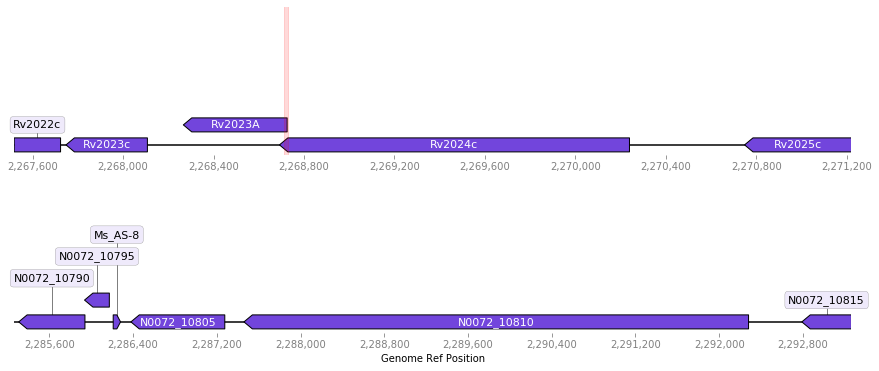

In [374]:
fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=False)
#fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=False)

Start_Coord = 2268720 - 1200
End_Coord = 2268720 + 2500


G1_Graphic_Record = BiopythonTranslator().translate_record(Mtb_H37rv_SeqIO_Record)

Mtb_H37rv_Graphic_Record_cropped = G1_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Mtb_H37rv_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs[0], plot_sequence = False)

axs[0].fill_between((2268720 - 10, 2268720 + 10), +1000, -1000, alpha=0.15, color = "red")




i_Bakta_GBFF_PATH = SampleTag_ToPaths_Dict["N0072"]["LRAsm_Bakta_GBFF"]

i_records = list(SeqIO.parse(i_Bakta_GBFF_PATH, "genbank"))
#print(sampleID, "- # of record =", len(i_records) )

i_Mtb_SeqIO_Record = i_records[0]
i_Mtb_Graphic_Record = BiopythonTranslator().translate_record(i_Mtb_SeqIO_Record)

N0072_Mtb_Graphic_Record = i_Mtb_Graphic_Record


G2_Graphic_record = N0072_Mtb_Graphic_Record

G2_Start_Coord = 2285767 - 500
G2_End_Coord = 2290762 + 2500

G2_Mtb_Graphic_Record_cropped = G2_Graphic_record.crop((G2_Start_Coord, G2_End_Coord + 1))
G2_Mtb_Graphic_Record_cropped.plot(strand_in_label_threshold=5, ax = axs[1], plot_sequence = False)

axs[0].fill_between((2285767- 10, 2290762 + 10), +1000, -1000, alpha=0.15, color = "blue")


axs[1].set(xlabel='Genome Ref Position')
plt.show()


# Preprocessing of k-mer analysis of nodes

In [375]:
MG_SVNodes_All_DF = MG_NodeAnalysis_DF.query("IsSVNode == True")
MG_SVNodes_All_DF.shape

(2601, 8)

In [376]:
MG_SVNodes_PASS_DF = MG_NodeAnalysis_DF.query("IsSVNode == True").query("SeqLength >= 31")     
MG_SVNodes_PASS_DF.shape

(2061, 8)

In [377]:
MG_SVNodes_TooSmall_DF = MG_NodeAnalysis_DF.query("IsSVNode == True").query("SeqLength < 31")     
MG_SVNodes_TooSmall_DF.shape

(540, 8)

In [378]:
MG_SVNodes_UnqSeq_DF =  MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiAllOtherNodes < 0.05")
MG_SVNodes_UnqSeq_DF.shape

(460, 8)

In [379]:
MG_SVNodes_UnqSeqToRv_DF = MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05")
MG_SVNodes_UnqSeqToRv_DF.shape

(159, 8)

# 10) Detect bubble regions with a high proportion of NOVEL content or NOVEL SV nodes
- Narrow down analysis to 10-20 regions to look at. (unique sequence, SVs between lineages(
- Visualize the regions of interest
- Plot SV alleles onto the phylogeny? 


In [380]:
SVNodes_UnqToGraph_DF_GrpByBubble = MG_SVNodes_UnqSeq_DF.groupby("BubbleID")
SVNodes_UnqToRv_DF_GrpByBubble = MG_SVNodes_UnqSeqToRv_DF.groupby("BubbleID")

MG_SVNodes_DF_GrpByBubble = MG_SVNodes_All_DF.groupby("BubbleID")

MG_SVNodes_DF_GrpByBubbleStats = MG_SVNodes_DF_GrpByBubble["Jaccard_Cont_WiAllOtherNodes"].describe()

MG_SVNodes_DF_GrpByBubbleStats["TotalLength"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(MG_SVNodes_DF_GrpByBubble["SeqLength"].sum().to_dict())

MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToRv"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(SVNodes_UnqToRv_DF_GrpByBubble["SeqLength"].sum().to_dict())
MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToRv"] = MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToRv"].fillna(0)

MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToGraph"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(SVNodes_UnqToGraph_DF_GrpByBubble["SeqLength"].sum().to_dict())
MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToGraph"] = MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToGraph"].fillna(0)

In [381]:
MG_SVNodes_DF_GrpByBubbleStats.shape

(533, 11)

In [382]:
MG_SVNodes_DF_GrpByBubbleStats.head(4)

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph
BubbleID,,,,,,,,,,,
BubbleRegion_10,1.0,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,904,0.0,904.0
BubbleRegion_100,1.0,1.000000,NaN,1.0,1.000000,1.000000,1.000000,1.000000,68,0.0,0.0
BubbleRegion_101,20.0,0.747216,0.442696,0.0,0.724736,1.000000,1.000000,1.000000,10412,0.0,0.0
BubbleRegion_102,2.0,0.499623,0.706574,0.0,0.249812,0.499623,0.749435,0.999247,1405,0.0,47.0


### How many bubbles have SEQ LENGTH UNQ to ALL NODES over 1 kb?

In [383]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToGraph > 1000 ").shape

(93, 11)

### How many bubbles have SEQ LENGTH UNQ to Rv over 1 kb?

In [384]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000").shape

(19, 11)

### How many bubbles have SEQ LENGTH UNQ to Rv and SeqLength Unq to Graph over 1 kb?

These represent some regions to take a look at. <br>
NOTE: Bubble_118 is likely the 4.4 kb region identified in the Lin 8 paper: https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/s41467-020-16626-6


In [385]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & SeqLength_UnqToGraph > 1000 ").shape

(17, 11)

In [386]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & SeqLength_UnqToGraph > 1000 & count <= 15").shape

(13, 11)

In [387]:
#MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & SeqLength_UnqToGraph > 1000 & count <= 15")

#### WILL FOCUS ON THESE FOR THESIS!

In [388]:
BubbleStats_RDsToRv_WiUnqSeq_DF = MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & SeqLength_UnqToGraph > 1000 & count <= 15 ")
BubbleStats_RDsToRv_WiUnqSeq_DF.shape

(13, 11)

In [389]:
BubbleStats_RDsToRv_WiUnqSeq_DF

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph
BubbleID,,,,,,,,,,,
BubbleRegion_103,4.0,0.253408,0.497769,0.000000,0.000000,0.006816,0.260224,1.000000,2210,1095.0,2152.0
BubbleRegion_118,2.0,0.512932,0.688818,0.025864,0.269398,0.512932,0.756466,1.000000,4541,4399.0,4399.0
BubbleRegion_196,3.0,0.333333,0.577350,0.000000,0.000000,0.000000,0.500000,1.000000,3511,2153.0,2153.0
BubbleRegion_267,13.0,0.577399,0.476133,0.000000,0.000000,0.883721,0.957746,1.000000,8232,5518.0,4482.0
BubbleRegion_382,2.0,0.000390,0.000552,0.000000,0.000195,0.000390,0.000585,0.000781,2441,1130.0,2441.0
BubbleRegion_397,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2725,1406.0,2725.0
BubbleRegion_405,4.0,0.250000,0.500000,0.000000,0.000000,0.000000,0.250000,1.000000,3722,1153.0,2364.0
BubbleRegion_411,13.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1859,1310.0,1807.0
BubbleRegion_413,6.0,0.797494,0.394510,0.000000,0.878088,0.965985,0.994650,1.000000,5517,1642.0,1642.0


In [390]:
BubbleStats_RDsToRv_WiUnqSeq_List = list(BubbleStats_RDsToRv_WiUnqSeq_DF.index)
#BubbleStats_DeletionsToRv_UnqSeq_List

In [391]:
MG_SV_BED_DF[MG_SV_BED_DF["BubbleID"].isin( BubbleStats_RDsToRv_WiUnqSeq_List )]

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,Overlap_Genes,Overlap_Gene_RvIDs
58,NC_000962.3,560425,561498,1001,1073,"s164,s2806,s165,s166",TACTGGCGAGCCGATACGATGCGCGCGCGCACAAATACTGCTACAA...,GCGTCAAGGTGACGATGAGCGATGTGCGGTTTATGAAATTCATCGG...,"[s2806, s165]",s164,s166,59,BubbleRegion_59,"umaA,pcaA","Rv0469,Rv0470c"
86,NC_000962.3,781845,783498,1530,1653,"s232,s2876,s233,s234",TCAACTGGCTGTCCAGCCGCATCACGCGCCAGAACTGCCGCCAGCA...,AGATCATCCGCGGTTCGCTGGATACGCAGGGTGTCAAGAACCGCAA...,"[s2876, s233]",s232,s234,87,BubbleRegion_87,"rpsL,rpsG,fusA1","Rv0682,Rv0683,Rv0684"
102,NC_000962.3,917629,918744,1057,1139,"s310,s311,s2751,s312,s313,s314",GCCCGCCTCCTGCTCATCGCGCTGCGCGCTCTGCATCGTCGCCGGG...,GCCCGCCTCCTGCTCATCGCGCTGCGCGCTCTGCATCGTCGCCGCC...,"[s311, s2751, s312, s313]",s310,s314,103,BubbleRegion_103,"Rv0823c,desA1","Rv0823c,Rv0824c"
117,NC_000962.3,1053645,1053787,142,4399,"s358,s2717,s359,s360",AAGTGGGCCTGATGGGCCCGATCGCCCGTCGCGCCTGGAAACGCAC...,CGTGAAACGACTCACCTCGGTAGTCGGCGCGCCCGGCGAAGTCCGG...,"[s2717, s359]",s358,s360,118,BubbleRegion_118,"Rv0943c,Rv0944","Rv0943c,Rv0944"
195,NC_000962.3,1761789,1761789,0,3511,"s587,s1795,s2721,s1796,s588",*,TGCTGGTTGCCGTGGCGGTGGTGGCGGTCGCGGGATTCAGCGTCTA...,"[s1795, s2721, s1796]",s587,s588,196,BubbleRegion_196,mmpL6,Rv1557
266,NC_000962.3,2268723,2268723,0,6459,"s839,s1845,s2796,s1847,s3137,s1846,s1846,s3137...",*,CAGCGTCCGGGCGTGCAGCACAGTCGAATCGAGTGCGTAGACCTGC...,"[s1845, s2796, s1847, s3137, s1846, s1846, s31...",s839,s840,267,BubbleRegion_267,"Rv2023A,Rv2024c","Rv2023A,Rv2024c"
381,NC_000962.3,3251646,3252957,1130,1311,"s1192,s2791,s1193,s1194",AGATTCATAAATTGGAGTAACGCATAGATACACTGTTTACAAGCCC...,GGGATTACGGGGTCCGGCGGTCGCGGTGGACACCGCCTGCTCGTCG...,"[s2791, s1193]",s1192,s1194,382,BubbleRegion_382,ppsB,Rv2932
396,NC_000962.3,3403272,3404591,1319,1406,"s1234,s2771,s1235,s1236",ATATGCGGGTAGTGCAGTTCGAACGCGGGACGCTCGGAGCGGATGC...,CCATATAAAAAAGTAGTGGTGCTCAGAACCGTGGAACGCCTGCGAA...,"[s2771, s1235]",s1234,s1236,397,BubbleRegion_397,ctaD,Rv3043c
404,NC_000962.3,3486249,3487460,1153,2569,"s1246,s3060,s1247,s2736,s1248,s1249",GTTCGCCATACTCCATACCCGCAGGCCGAGGTCATGAAGTCGGTGA...,ACCGACCGCGCCGCCTCCCACCCGCGGAAGCTAACGAGGTGTGCAT...,"[s3060, s1247, s2736, s1248]",s1246,s1249,405,BubbleRegion_405,cyp141,Rv3121
410,NC_000962.3,3501223,3501723,0,1837,"s1258,s1259,s2412,s1260,s1261,s2085,s2297,s229...",*,CACTCGGAGCCGCTCGTGACCATGGGGGGAGCCACTGCCGTCTCCC...,"[s1259, s2412, s1260, s1261, s2085, s2297, s22...",s1258,s1264,411,BubbleRegion_411,PPE50,Rv3135


In [392]:
#MG_SVInfo_DF[MG_SVInfo_DF["BubbleID"].isin( BubbleStats_RDsToRv_WiUnqSeq_List )]

In [393]:
MG_SVVCF_Mod_RD_Rv2024c_DF = MG_SVVCF_Mod_DF.query("BubbleID == 'BubbleRegion_267'")

In [394]:
MG_SVVCF_Mod_RD_Rv2024c_DF

,Chr,Pos,FILTER,BubbleID,Start_Node,End_Node,NodePath_Trimmed,Info,FORMAT,NA,AWALK_Full,AWALK_List,NC_000962.3,mada_1-40,mada_1-44,mada_2-46,mada_107,mada_1-1,mada_1-51,mada_1-39,mada_122,mada_1-36,mada_117,mada_118,mada_1-10,N0072,N0153,R27252,R23887,R30078,R28012,R27657,R30234,R31095,R28703,R24120,MFS-3,R36431,R29816,MFS-42,DNA096,DNA114,DNA028,706-05,DNA089,9050-05,3003-06,702-06,DNA019_Vash,696-05,8651-04,DNA091,4549-04,ARR1960,AZE_02_041,ZRB10578980,8129-04,DNA075,AZE_02_067,R30215,R25048,MFS-59,MFS-58,R29598,R24100,R28581,MFS-173,MFS-51,MFS-52,MFS-54,N0145,mada_1-11,N0155,mada_115,mada_2-42,M0003941_3,R37765,18_0621851,R27937,R22601,R18040,R18043,R27725,R26791,R20574,R20260,R21408,R23146,R28980,R26778,R32929,R30420,R21893,QC-9,QC-5,QC-3,N0004,mada_1-30,N0054,N1274,mada_1-53,mada_2-53,mada_1-50,mada_2-1,R23571,mada_1-2,mada_123,8644-04,mada_128,mada_1-12,mada_1-15,DNA120,mada_1-38,01_R1134,mada_126,mada_120,DNA124,M0016737_0,DNA054,mada_112,mada_124,mada_103,MFS-60,MFS-61,MFS-181,02_R1896,mada_2-25,DNA020,M0011368_9,01_R1430,AZE_02_042,DNA086,DNA182,02_R1179,QC-6,QC-1,QC-7,M0010874_7,M0016395_7,R15311,DNA044,M0014888_3,mada_151,DNA188,mada_105,QC-8,QC-10,QC-4,mada_129,02_R1708,02_R0894,mada_139,DNA019_Rose,MT_0080,mada_102,R21839,R21363,R21770,R30396,R20896,mada_1-32,MFS-56,M0017522_5,mada_2-31,mada_1-41,N1272,N1176,N0091,N1202,N1177,RW-TB008
BubbleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BubbleRegion_267,NC_000962.3,2268723,PASS,BubbleRegion_267,s839,s840,"[s1845, s2796, s1847, s3137, s1846, s1846, s31...","NS=159;NA=6;ALEN=5000,0,6359,6359,6358,6358;AC...",GT:GT0,6,">s1845>s1846>s1847>s1848>s1849>s1850,*,>s1845>...","[>s1845>s1846>s1847>s1848>s1849>s1850, *, >s18...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [395]:
dictOf_RD_Rv2024c_PresAbs = {}

for i, row in MG_SVVCF_Mod_RD_Rv2024c_DF.iterrows():
    
    i_BubbleID = row["BubbleID"]
    print(i_BubbleID)
    for sampleID in SampleIDs_158CI_SOI:
        
        Sample_Allele = row[sampleID] #.values[0]
        
        if Sample_Allele == 0:
            dictOf_RD_Rv2024c_PresAbs[sampleID] = 0
        else:
            dictOf_RD_Rv2024c_PresAbs[sampleID] = 1

    #print(row)
    #if i >= 0: break

BubbleRegion_267


In [396]:
dictOf_RD_Rv2024c_MultiAllele = {}

for i, row in MG_SVVCF_Mod_RD_Rv2024c_DF.iterrows():
    for sampleID in SampleIDs_158CI_SOI:
        
        Sample_Allele = row[sampleID] #.values[0]
        
        dictOf_RD_Rv2024c_MultiAllele[sampleID] = Sample_Allele
        
        # if Sample_Allele == 0: dictOf_Tbd1_PresAbs[sampleID] = 0
        # else: dictOf_Tbd1_PresAbs[sampleID] = Sample_Allele

    #print(row)
    #if i >= 0: break

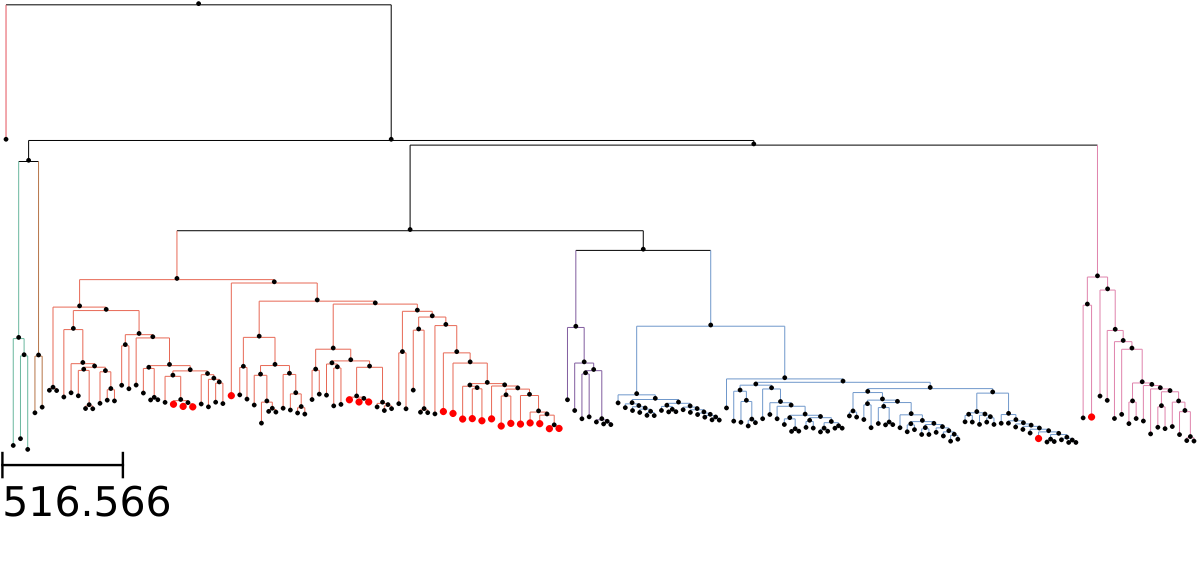

In [397]:
Tree_NumEvents_Labeled = labelLeafsByPresAbs_SV(dictOf_RD_Rv2024c_PresAbs, i_Gubbins_T)

Tree_NumEvents_Labeled.render("%%inline", w = 1200, tree_style = ts_3)

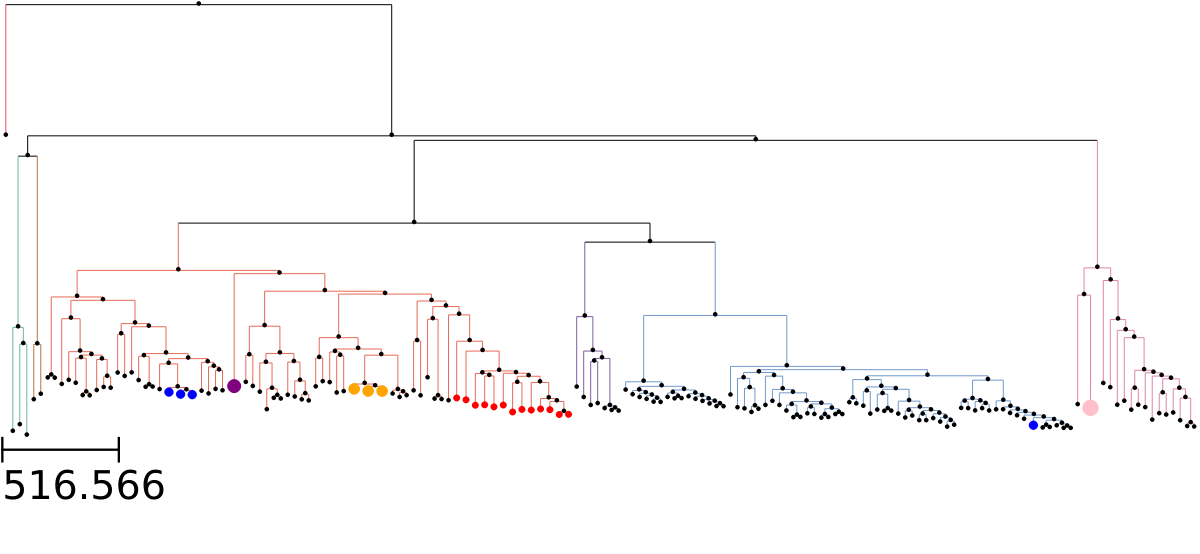

In [398]:
Tree_NumEvents_Labeled = labelLeafsByPresAbs_SV(dictOf_RD_Rv2024c_MultiAllele, i_Gubbins_T)

Tree_NumEvents_Labeled.render("%%inline", w = 1200, tree_style = ts_3)

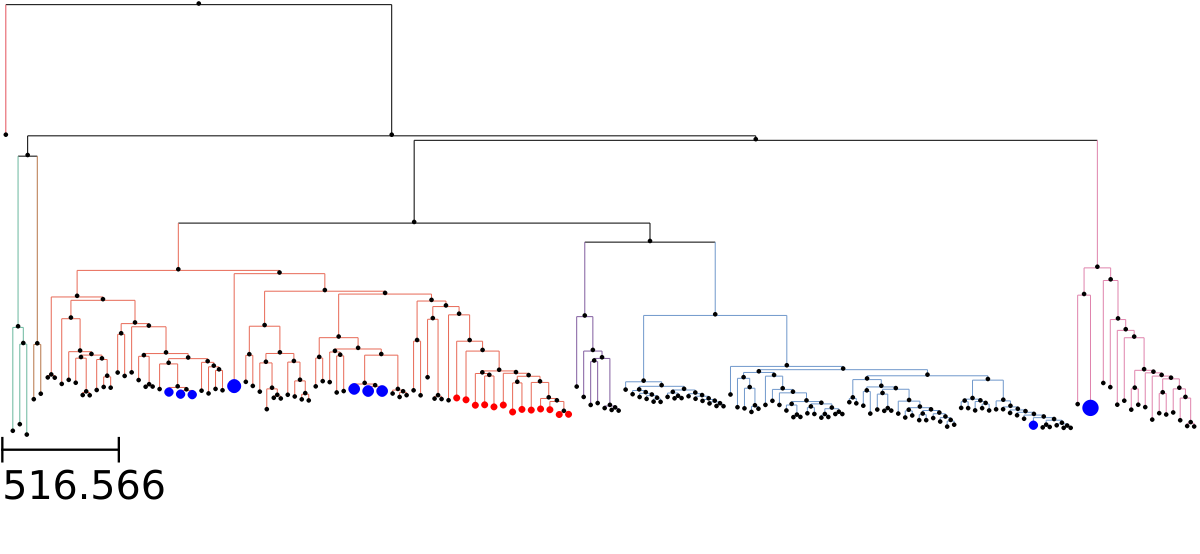

In [399]:
Tree_NumEvents_Labeled = labelLeafsByPresAbs_SV_0to2(dictOf_RD_Rv2024c_MultiAllele, i_Gubbins_T)

Tree_NumEvents_Labeled.render("%%inline", w = 1200, tree_style = ts_3)

## Let's look at Bubble_118

In [400]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_118' ")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,Overlap_Genes,Overlap_Gene_RvIDs
117,NC_000962.3,1053645,1053787,142,4399,"s358,s2717,s359,s360",AAGTGGGCCTGATGGGCCCGATCGCCCGTCGCGCCTGGAAACGCAC...,CGTGAAACGACTCACCTCGGTAGTCGGCGCGCCCGGCGAAGTCCGG...,"[s2717, s359]",s358,s360,118,BubbleRegion_118,"Rv0943c,Rv0944","Rv0943c,Rv0944"


In [401]:
#dictOf_SVAlleles_PerBubble.keys()

In [402]:
#dictOf_SVAlleles_PerBubble["BubbleRegion_118"]

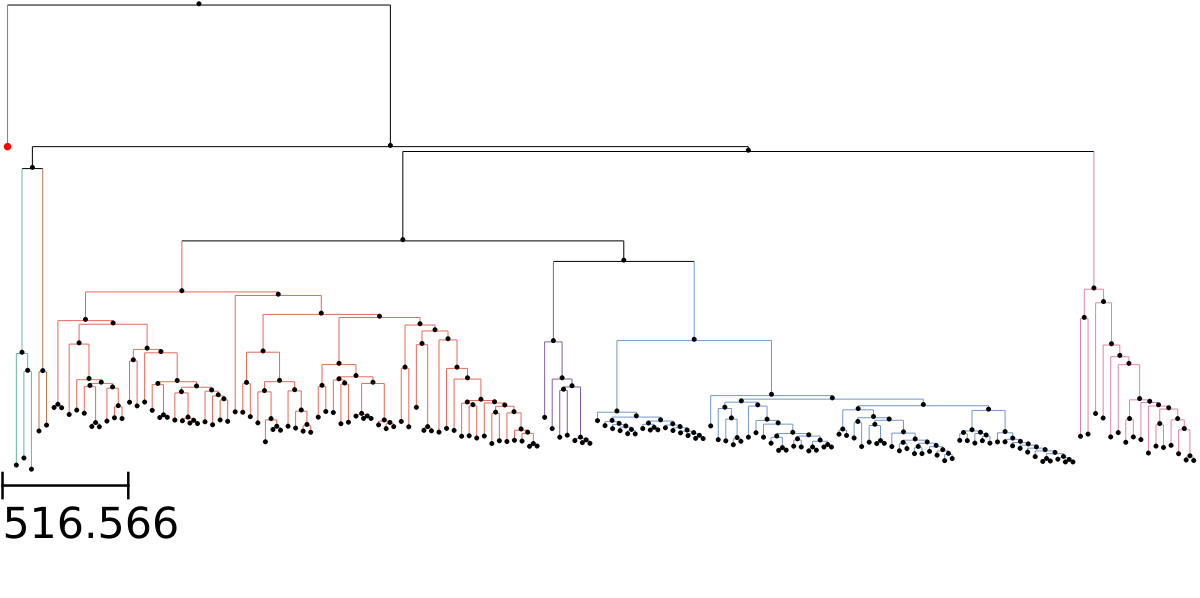

In [403]:
Tree_NumEvents_Labeled = labelLeafsByPresAbs_SV(dictOf_SVAlleles_PerBubble["BubbleRegion_118"], i_Gubbins_T)

Tree_NumEvents_Labeled.render("%%inline", w = 1200, tree_style = ts_3)

## Run clinker to VIZ Bubble_118 regions

In [404]:
MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_118'")

,Chr,Start,End,Info,FORMAT,NA,BubbleNum,BubbleID,NC_000962.3,mada_1-40,mada_1-44,mada_2-46,mada_107,mada_1-1,mada_1-51,mada_1-39,mada_122,mada_1-36,mada_117,mada_118,mada_1-10,N0072,N0153,R27252,R23887,R30078,R28012,R27657,R30234,R31095,R28703,R24120,MFS-3,R36431,R29816,MFS-42,DNA096,DNA114,DNA028,706-05,DNA089,9050-05,3003-06,702-06,DNA019_Vash,696-05,8651-04,DNA091,4549-04,ARR1960,AZE_02_041,ZRB10578980,8129-04,DNA075,AZE_02_067,R30215,R25048,MFS-59,MFS-58,R29598,R24100,R28581,MFS-173,MFS-51,MFS-52,MFS-54,N0145,mada_1-11,N0155,mada_115,mada_2-42,M0003941_3,R37765,18_0621851,R27937,R22601,R18040,R18043,R27725,R26791,R20574,R20260,R21408,R23146,R28980,R26778,R32929,R30420,R21893,QC-9,QC-5,QC-3,N0004,mada_1-30,N0054,N1274,mada_1-53,mada_2-53,mada_1-50,mada_2-1,R23571,mada_1-2,mada_123,8644-04,mada_128,mada_1-12,mada_1-15,DNA120,mada_1-38,01_R1134,mada_126,mada_120,DNA124,M0016737_0,DNA054,mada_112,mada_124,mada_103,MFS-60,MFS-61,MFS-181,02_R1896,mada_2-25,DNA020,M0011368_9,01_R1430,AZE_02_042,DNA086,DNA182,02_R1179,QC-6,QC-1,QC-7,M0010874_7,M0016395_7,R15311,DNA044,M0014888_3,mada_151,DNA188,mada_105,QC-8,QC-10,QC-4,mada_129,02_R1708,02_R0894,mada_139,DNA019_Rose,MT_0080,mada_102,R21839,R21363,R21770,R30396,R20896,mada_1-32,MFS-56,M0017522_5,mada_2-31,mada_1-41,N1272,N1176,N0091,N1202,N1177,RW-TB008
117,NC_000962.3,1053645,1053787,"NS=159;NA=2;ALEN=142,4399;AC=158,1;VS=>s358;VE...",GT:CSTRAND:CTG:CS:CE,2,118,BubbleRegion_118,0:+:NC_000962.3:1053643:1053787,0:+:mada_1-40:1054351:1054495,0:+:mada_1-44:1051857:1052001,0:+:mada_2-46:1046245:1046389,0:+:mada_107:1055843:1055987,0:+:mada_1-1:1054917:1055061,0:+:mada_1-51:1054933:1055077,0:+:mada_1-39:1054146:1054290,0:+:mada_122:1054602:1054746,0:+:mada_1-36:1054551:1054695,0:+:mada_117:1051183:1051327,0:+:mada_118:1057043:1057187,0:+:mada_1-10:1056661:1056805,0:+:N0072:1057559:1057703,0:+:N0153:1054230:1054374,0:+:R27252:1056540:1056684,0:+:R23887:1065451:1065595,0:+:R30078:1053486:1053630,0:+:R28012:1053482:1053626,0:+:R27657:1053488:1053632,0:+:R30234:1053486:1053630,0:+:R31095:1053488:1053632,0:+:R28703:1053493:1053637,0:+:R24120:1053486:1053630,0:+:MFS-3:1054838:1054982,0:+:R36431:1053480:1053624,0:+:R29816:1053487:1053631,0:+:MFS-42:1054741:1054885,0:-:DNA096:3360340:3360484,0:-:DNA114:3361702:3361846,0:-:DNA028:3360425:3360569,0:-:706-05:3361625:3361769,0:-:DNA089:3360192:3360336,0:+:9050-05:1049120:1049264,0:+:3003-06:1049123:1049267,0:+:702-06:1049121:1049265,0:+:DNA019_Vash:1049102:1049246,0:+:696-05:1049127:1049271,0:+:8651-04:1049075:1049219,0:+:DNA091:1049095:1049239,0:+:4549-04:1050531:1050675,0:+:ARR1960:1049101:1049245,0:+:AZE_02_041:1051981:1052125,0:+:ZRB10578980:1051981:1052125,0:+:8129-04:1052036:1052180,0:+:DNA075:1051971:1052115,0:+:AZE_02_067:1053382:1053526,0:+:R30215:1052249:1052393,0:+:R25048:1046922:1047066,0:+:MFS-59:1053135:1053279,0:+:MFS-58:1053078:1053222,0:+:R29598:1053143:1053287,0:+:R24100:1053147:1053291,0:+:R28581:1053148:1053292,0:+:MFS-173:1053127:1053271,0:+:MFS-51:1053095:1053239,0:+:MFS-52:1053137:1053281,0:+:MFS-54:1053139:1053283,0:+:N0145:1051848:1051992,0:+:mada_1-11:1051764:1051908,0:+:N0155:1052247:1052391,0:+:mada_115:1052321:1052465,0:+:mada_2-42:1052126:1052270,0:+:M0003941_3:1052323:1052467,0:+:R37765:1052119:1052263,0:+:18_0621851:1052008:1052152,0:+:R27937:1052657:1052801,0:+:R22601:1052658:1052802,0:+:R18040:1052657:1052801,0:+:R18043:1052671:1052815,0:+:R27725:1052659:1052803,0:+:R26791:1052660:1052804,0:+:R20574:1052669:1052813,0:+:R20260:1052665:1052809,0:+:R21408:1052661:1052805,0:+:R23146:1052667:1052811,0:+:R28980:1052665:1052809,0:+:R26778:1052662:1052806,0:+:R32929:1052654:1052798,0:+:R30420:1052707:1052851,0:+:R21893:1054024:1054168,0:+:QC-9:1058906:1059050,0:+:QC-5:1058905:1059049,0:+:QC-3:1058916:1059060,0:+:N0004:1058543:1058687,0:+:mada_1-30:1069522:1069666,0:+:N0054:1059739:1059883,0:+:N1274:1059181:1059325,0:+:mada_1-53:1053673:1053817,0:+:mada_2-53:1053667:1053811,0:+:mada_1-50:1053663:1053807,0:+:mada_2-1:1053690

In [405]:
MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_118'")["N0072"]

117    0:+:N0072:1057559:1057703
Name: N0072, dtype: object

### Coord notes for Bubble 118
0:+:NC_000962.3:1053643:1053787

1:+:RW-TB008:1050420:1054821
0:+:N0072:1057559:1057703



In [406]:
SampleTag_ToPaths_Dict["RW-TB008"]["LRAsm_Bakta_GBFF"]


H37rv_Ref_GBK_PATH = "/n/data1/hms/dbmi/farhat/mm774/References/GCF_000195955.2_ASM19595v2_genomic.gbk"


In [407]:
#!clinker --help

In [408]:
!mkdir Bubble118_Viz/

H37rv_Bakta_GBK_PATH = "/n/data1/hms/dbmi/farhat/mm774/Projects/MtbPangenomeComp/MtbPangenomeExploration/Data/230302.PGAPvsBakta.Plots/H37Rv/Bakta_annotation_H37Rv/H37Rv.gbff"       

Bubble118_Viz_HTML = f"Bubble118_Viz/clinkerviz.Bubble118.test1.html"

Rv_GBK = "/n/data1/hms/dbmi/farhat/mm774/References/GCF_000195955.2_ASM19595v2_genomic.gbk"
Rv_2_GBK = H37rv_Bakta_GBK_PATH
N0072_GBK = SampleTag_ToPaths_Dict["N0072"]["LRAsm_Bakta_GBFF"]
RWTB008_GBK = SampleTag_ToPaths_Dict["RW-TB008"]["LRAsm_Bakta_GBFF"]

i_Ranges = "NC_000962.3:1051643-1056787 contig_1:1051643-1056787 contig_1:1051559-1060703 contig_1:1044420-1060821"

!clinker $Rv_GBK $Rv_2_GBK $N0072_GBK $RWTB008_GBK --ranges $i_Ranges --identity 0.3 --use_file_order -p $Bubble118_Viz_HTML


mkdir: cannot create directory ‘Bubble118_Viz/’: File exists
[09:20:55] INFO - Starting clinker
[09:20:55] INFO - Parsing files:
[09:20:55] INFO -   GCF_000195955.2_ASM19595v2_genomic.gbk
[09:20:56] INFO -     Parsing range NC_000962.3:1051642-1056787
[09:20:56] INFO -   H37Rv.gbff
[09:20:57] INFO -     Parsing range contig_1:1044419-1060821
[09:20:57] INFO -   N0072.Bakta.gbff
[09:20:57] INFO -     Parsing range contig_1:1044419-1060821
[09:20:57] INFO -   RW-TB008.Bakta.gbff
[09:20:58] INFO -     Parsing range contig_1:1044419-1060821
[09:20:58] INFO - Starting cluster alignments
[09:20:58] INFO - GCF_000195955.2_ASM19595v2_genomic vs H37Rv
[09:20:58] INFO - GCF_000195955.2_ASM19595v2_genomic vs N0072.Bakta
[09:20:58] INFO - GCF_000195955.2_ASM19595v2_genomic vs RW-TB008.Bakta
[09:20:58] INFO - H37Rv vs N0072.Bakta
[09:20:58] INFO - H37Rv vs RW-TB008.Bakta
[09:20:58] INFO - N0072.Bakta vs RW-TB008.Bakta
[09:21:00] INFO - Generating results summary...
GCF_000195955.2_ASM19595v2_genomi

## Bubble region 3 (Rv0010c-Rv0011c)

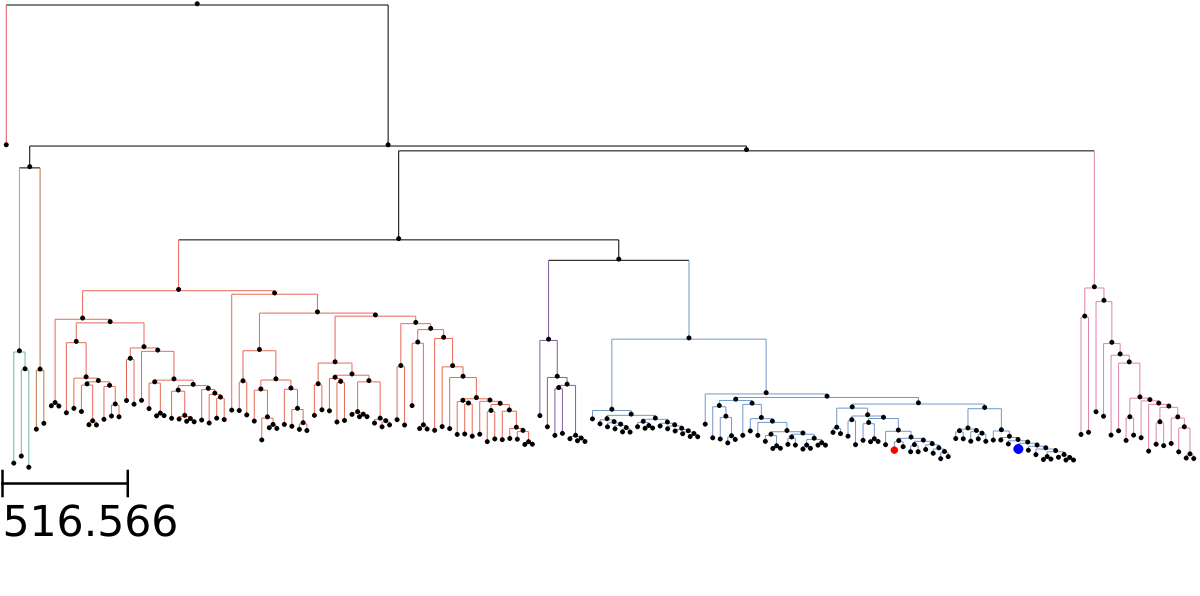

In [416]:
Tree_NumEvents_Labeled = labelLeafsByPresAbs_SV(dictOf_SVAlleles_PerBubble["BubbleRegion_3"], i_Gubbins_T)

Tree_NumEvents_Labeled.render("%%inline", w = 1200, tree_style = ts_3)